In [83]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from dataclasses import dataclass

from pydrake.all import (MathematicalProgram, Solve, MonomialBasis,
                         DiagramBuilder, Evaluate, LogVectorOutput, Simulator,
                         SymbolicVectorSystem, Variable, ToLatex, Polynomial,
                         VectorSystem, eq, Formula, Expression)




In [36]:
def create_numpy_array(string):
    # Split the string by space
    values = string.split()
    # Convert the values to float
    return np.array([float(value) for value in values])

w11c_ans_str = "4.5868 -0.0237 0.1742 2.0684 0.1005 2.7412 -0.0038 -0.0333 0.1304 0.2714 2.4268 -0.2897 2.1171 0.0132 6.9634 0.0005 0.0150 -0.0203 0.0001 0.0031 0.0000 0.0001 0.0006 0.0934 0.0116 0.0234 -0.0000 0.0000"
w12c_ans_str = "-1.8328 0.0654 -0.1007 -0.3102 -0.0460 -2.5568 0.0001 0.0177 -0.0427 -0.0515 -0.2710 0.0327 -0.2791 0.0207 -1.3630 -0.0000 -0.0015 0.0048 -0.0120 0.0013 0.0000 0.0000 -0.0001 -0.0092 -0.0054 -0.0031 -0.0000 0.0000"
w22c_ans_str = "7.2139 -0.0124 0.0012 0.0618 0.0954 1.1859 0.0000 -0.0034 0.0088 0.0296 0.0303 -0.0002 0.0377 0.0987 0.4190 0.0000 0.0001 -0.0010 0.0016 -0.0007 -0.0000 0.0000 0.0000 0.0013 0.0012 0.0059 -0.0000 0.0000"
l1c_ans_str = "-3.3514 -0.0118 0.2920 -2.0838 0.1256 -1.6818 0.0136 -0.2138 0.1707 0.0306 -2.6709 0.3296 -2.2965 0.1873 -4.8506 -0.0282 0.2366 -0.1405 0.5670 -0.1170 0.6971 -0.0001 0.0009 -0.0998 -0.0076 -0.0427 0.0003 0.0000"
l2c_ans_str = "0.1711 0.6323 -0.1381 0.2945 -0.4221 0.3728 0.0011 0.0007 0.0482 -0.3245 0.2982 -0.0407 0.2632 -0.3511 0.4786 0.0031 -0.0261 0.0159 -0.0331 0.0474 -0.1364 0.0000 0.0001 0.0097 0.0053 0.0016 0.0001 0.0000"

w11c_ans = create_numpy_array(w11c_ans_str)
w12c_ans = create_numpy_array(w12c_ans_str)
w22c_ans = create_numpy_array(w22c_ans_str)
l1c_ans = create_numpy_array(l1c_ans_str)
l2c_ans = create_numpy_array(l2c_ans_str)

In [59]:
prog = MathematicalProgram()
deg = 6
# Convergence rate = 1-beta
beta = 0.1
# Indeterminates
x = prog.NewIndeterminates(2, 'x_{k}')
u = prog.NewIndeterminates(1, 'u_{k}')
w = prog.NewIndeterminates(4, 'w')

# A and B matrices
Ak = np.array([[1.1-0.1*x[1],   0],
               [0.1         ,   0.9]])
Bk = np.array([1, 0])[:, np.newaxis]

# Monomial basis
v = [monomial.ToExpression() for monomial in MonomialBasis(x, deg)]
v_next = [vk.Substitute({x[0]: 1.1*x[0] - 0.1*x[0]*x[1] + u[0],
                         x[1]: 0.9*x[1] + 0.9*x[0]}) for vk in v]
# print("v: ", v)
# print("v_next: ", v_next)
dim_v = len(v)
w11c = prog.NewContinuousVariables(dim_v, 'w11c')
w12c = prog.NewContinuousVariables(dim_v, 'w12c')
w22c = prog.NewContinuousVariables(dim_v, 'w22c')
# print("w11c: ", w11c)

W11k = w11c.dot(v)
W12k = w12c.dot(v)
W22k = w22c.dot(v)
Wk = np.array([[W11k, W12k], [W12k, W22k]])
# print("W11k: ", W11k)


W11k_next = w11c.dot(v_next)
W12k_next = w12c.dot(v_next)
W22k_next = w22c.dot(v_next)
Wk_next = np.array([[W11k_next, W12k_next], [W12k_next, W22k_next]])

r = prog.NewContinuousVariables(1, 'r')

l1c = prog.NewContinuousVariables(dim_v, 'l1c')
l2c = prog.NewContinuousVariables(dim_v, 'l2c')

L1k = l1c.dot(v)
L2k = l2c.dot(v)
Lk = np.array([[L1k, L2k]])

print("Wk: ", Wk.shape)
print("Ak: ", Ak.shape)
print("Bk: ", Bk.shape)
print("Lk: ", Lk.shape)

prog.AddLinearCost(r[0])
prog.AddLinearConstraint(r[0] >= 0)

v = np.array(v).reshape(-1, 1)
print("v: ", v.shape)
w = np.array(w).reshape(-1, 1)

cross_diag = Ak @ Wk + Bk @ Lk
omega = np.block([[Wk_next, cross_diag],
                 [cross_diag.T, (1-beta)*Wk]])
print("omega: ", omega.shape)
# Note: w is an additional indeterminate that enforces that omega is PSD

prog.AddSosConstraint((w.T @ omega @ w - r[0]).flatten()[0])

# Verify that the solution is meets constraints:
# prog.SetInitialGuess(w11c, w11c_ans)
# prog.SetInitialGuess(w12c, w12c_ans)
# prog.SetInitialGuess(w22c, w22c_ans)
# prog.SetInitialGuess(l1c, l1c_ans)
# prog.SetInitialGuess(l2c, l2c_ans)

result = Solve(prog)
print("Solver succeeded: ", result.is_success())

infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"infeasible constraint: {c}")

# Extract the solution
print("w11c:\n", result.GetSolution(w11c))
print("\nw12c:\n", result.GetSolution(w12c))
print("\nw22c:\n", result.GetSolution(w22c))
print("\nl1c:\n", result.GetSolution(l1c))
print("\nl2c:\n", result.GetSolution(l2c))

Wk:  (2, 2)
Ak:  (2, 2)
Bk:  (2, 1)
Lk:  (1, 2)
v:  (28, 1)
omega:  (4, 4)
Solver succeeded:  True
w11c:
 [ 0.00000000e+00 -5.23900750e-09  5.96682819e-03 -1.61740484e-03
  1.04316892e-02  1.23850267e-05  1.85008500e-05 -5.52459646e-08
 -1.04307101e-03 -1.96562948e-03 -1.05569158e-03  1.14496284e-03
  4.96479694e-05  3.97380313e+00 -1.42521088e+00  1.91279816e+00
 -1.11442531e+00  8.05875901e-01  1.12930394e-03  1.86070945e-01
  5.48891532e-02 -1.83340988e-02  3.11937582e+00 -7.36537319e-01
  1.78567417e+00  3.95063261e-02  3.41411653e-02  3.34384010e+00]

w12c:
 [ 0.00000000e+00 -2.81913170e-09 -6.47272716e-04  2.41881745e-04
 -1.16033761e-03 -1.91876852e-06 -2.05654398e-06 -4.87859767e-06
 -1.86268570e-04  6.29914874e-05 -2.00831171e-03 -1.35727439e-03
 -7.29866200e-06 -4.57423852e-01  1.17051439e-01 -2.15845595e-01
  1.38172839e-01 -9.15807122e-02 -6.66191111e-03 -2.98832318e-03
 -1.41210333e-02  3.72793622e-03 -2.29573884e+00  2.38007229e-01
 -1.77766752e-01 -1.69251066e-02 -3.0284

In [30]:
def display_expression(label:str, expr):
    display(
        Markdown(
            f"${label} = "
            + ToLatex(
                Polynomial(expr)
                .RemoveTermsWithSmallCoefficients(1e-5)
                .ToExpression(),
                6,
            )
            + "$"
        )
    )

In [98]:
@dataclass
class DCCMOnlineParams:
    """
    Parameters for the DCCM controller to run online.
    """
    w11c: np.ndarray
    w12c: np.ndarray
    w22c: np.ndarray
    l1c: np.ndarray
    l2c: np.ndarray

    # System parameters
    dim_x: int = 2 # Dimension of the state

    # DCCM Params
    deg: int = 6 # Degree of the polynomial

    # Geodesic calculation parameters
    N: int = 100 # Number of segments to discretize the geodesic into
    

    
class DCCMOnlineController(VectorSystem):
    def __init__(self, params: DCCMOnlineParams):
        # 2 inputs: CSTR state x
        # 1 output: command u
        VectorSystem.__init__(self, params.dim_x, 1)
        self.params = params

    
    def DoCalcVectorOutput(
            self,
            context,
            controller_input, # CSTR state
            controller_state, # unused input (static controller)
            controller_output # command u
        ):

        # unpack state
        x = controller_input

        t = context.get_time()
        # desired trajectory
        x_d = self.desired_trajectory(t)
        Lk = np.array([[self.params.l1c.dot(v), self.params.l2c.dot(v)]])
        
        # controller
        # controller_output[:] = [
        #     prog = MathematicalProgram()
        # ]
    
    def calculate_geodesic(self, x0, x1, t: float):
        """
        Calculate the geodesic from x0 to x1.
        Based on optimization (27)
        Args:
            x0: (dim_x,): initial state, will correspond to x_k
            x1: (dim_x,): final state, will correspond to x*_k
        """
        prog = MathematicalProgram()
        
        # Numerical state evaluation along the geodesic
        x = prog.NewContinuousVariables(self.params.N, self.params.dim_x, 'x')

        # Displacement vector discretized wrt s parameter
        delta_xs = prog.NewContinuousVariables(self.params.N, self.params.dim_x, '\delta x_s')
        
        # Small positive scaler value
        delta_s = prog.NewContinuousVariables(self.params.N, 's')

        # Add constraints
        # Constraint 1
        si_sum_to_one = prog.AddLinearConstraint(sum(delta_s) == 1)

        discrete_distances_sum = x0
        for i in range(self.params.N):
            discrete_distances_sum = discrete_distances_sum + delta_s[i] * delta_xs[i]
            # Constraint 2: Intermediate state matches sum of deltas

            prog.AddConstraint(eq(x[i], discrete_distances_sum))
        # Constraint 3
        total_distances_match = prog.AddConstraint(eq(discrete_distances_sum, x1))
    
        # Sum cost over all segments
        # total_cost = 0
        for i in range(self.params.N):
            v = [monomial.ToExpression() for monomial in MonomialBasis(x[i], deg)]
            # Construct W(x_i)
            W11i = w11c.dot(v)
            W12i = w12c.dot(v)
            W22i = w22c.dot(v)
            Wi = np.array([[W11i, W12i], [W12i, W22i]])
            # Get M(x_i) by inverting W(x_i)
            Mi = self.get_2x2_inverse(Wi) # <= because of the division, this is not a polynomial anymore!!!
            # Add quadratic cost
            cost = delta_s[i] * delta_xs[i].T @ Mi @ delta_xs[i]
            prog.AddCost(Polynomial(cost))
            # total_cost += delta_s[i] * delta_xs[i].T @ Mi @ delta_xs[i]
        # Add cost to program
        # prog.AddCost(total_cost)
        result = Solve(prog)
        print(f"Solver succeeded({result.is_success()}) at t={t}", )

        return result.GetSolution(delta_xs), result.GetSolution(delta_s)
    
    def desired_trajectory(self, t):
        if t < 3.3:
            x_d = 0
        elif t < 6.6:
            x_d = 1
        else:
            x_d = 0.5
        return np.ones(2) * x_d
    
    def get_2x2_inverse(self, A: np.array):
        # This doesn't work: np.linalg.inv(A)
        det = A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0]
        return np.array([[A[1, 1], -A[0, 1]], [-A[1, 0], A[0, 0]]]) / det
         

def geodesic_test():
    # Test the geodesic calculation
    x0 = np.array([0, 0])
    x1 = np.array([1, 1])
    t = 0
    params = DCCMOnlineParams(w11c_ans, w12c_ans, w22c_ans, l1c_ans, l2c_ans)
    controller = DCCMOnlineController(params)
    delta_xs, delta_s = controller.calculate_geodesic(x0, x1, t)
    print("delta_xs: ", delta_xs)
    print("delta_s: ", delta_s)

geodesic_test()

RuntimeError: In ((w11c(0) * pow(x(0,1), 6) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(1) * x(0,0) * pow(x(0,1), 5) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(2) * pow(x(0,0), 2) * pow(x(0,1), 4) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(3) * pow(x(0,0), 3) * pow(x(0,1), 3) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(4) * pow(x(0,0), 4) * pow(x(0,1), 2) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(5) * pow(x(0,0), 5) * x(0,1) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(6) * pow(x(0,0), 6) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(7) * pow(x(0,1), 5) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(8) * x(0,0) * pow(x(0,1), 4) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(9) * pow(x(0,0), 2) * pow(x(0,1), 3) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(10) * pow(x(0,0), 3) * pow(x(0,1), 2) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(11) * pow(x(0,0), 4) * x(0,1) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(12) * pow(x(0,0), 5) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(13) * pow(x(0,1), 4) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(14) * x(0,0) * pow(x(0,1), 3) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(15) * pow(x(0,0), 2) * pow(x(0,1), 2) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(16) * pow(x(0,0), 3) * x(0,1) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(17) * pow(x(0,0), 4) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(18) * pow(x(0,1), 3) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(19) * x(0,0) * pow(x(0,1), 2) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(20) * pow(x(0,0), 2) * x(0,1) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(21) * pow(x(0,0), 3) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(22) * pow(x(0,1), 2) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(23) * x(0,0) * x(0,1) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(24) * pow(x(0,0), 2) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(25) * x(0,1) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(26) * x(0,0) * pow(\delta x_s(0,1), 2) * s(0)) + (w11c(27) * pow(\delta x_s(0,1), 2) * s(0))) / ((w11c(0) * w22c(0) * pow(x(0,1), 12)) + (w11c(0) * w22c(1) * x(0,0) * pow(x(0,1), 11)) + (w11c(0) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 10)) + (w11c(0) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(0) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(0) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(0) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(0) * w22c(7) * pow(x(0,1), 11)) + (w11c(0) * w22c(8) * x(0,0) * pow(x(0,1), 10)) + (w11c(0) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(0) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(0) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(0) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(0) * w22c(13) * pow(x(0,1), 10)) + (w11c(0) * w22c(14) * x(0,0) * pow(x(0,1), 9)) + (w11c(0) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(0) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(0) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(0) * w22c(18) * pow(x(0,1), 9)) + (w11c(0) * w22c(19) * x(0,0) * pow(x(0,1), 8)) + (w11c(0) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(0) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(0) * w22c(22) * pow(x(0,1), 8)) + (w11c(0) * w22c(23) * x(0,0) * pow(x(0,1), 7)) + (w11c(0) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(0) * w22c(25) * pow(x(0,1), 7)) + (w11c(0) * w22c(26) * x(0,0) * pow(x(0,1), 6)) + (w11c(0) * w22c(27) * pow(x(0,1), 6)) + (w11c(1) * w22c(0) * x(0,0) * pow(x(0,1), 11)) + (w11c(1) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 10)) + (w11c(1) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(1) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(1) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(1) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(1) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(1) * w22c(7) * x(0,0) * pow(x(0,1), 10)) + (w11c(1) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(1) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(1) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(1) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(1) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(1) * w22c(13) * x(0,0) * pow(x(0,1), 9)) + (w11c(1) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(1) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(1) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(1) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(1) * w22c(18) * x(0,0) * pow(x(0,1), 8)) + (w11c(1) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(1) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(1) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(1) * w22c(22) * x(0,0) * pow(x(0,1), 7)) + (w11c(1) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(1) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(1) * w22c(25) * x(0,0) * pow(x(0,1), 6)) + (w11c(1) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(1) * w22c(27) * x(0,0) * pow(x(0,1), 5)) + (w11c(2) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 10)) + (w11c(2) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(2) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(2) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(2) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(2) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(2) * w22c(6) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(2) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(2) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(2) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(2) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(2) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(2) * w22c(12) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(2) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(2) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(2) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(2) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(2) * w22c(17) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(2) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(2) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(2) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(2) * w22c(21) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(2) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(2) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(2) * w22c(24) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(2) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(2) * w22c(26) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(2) * w22c(27) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(3) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(3) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(3) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(3) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(3) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(3) * w22c(5) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(3) * w22c(6) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(3) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(3) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(3) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(3) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(3) * w22c(11) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(3) * w22c(12) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(3) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(3) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(3) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(3) * w22c(16) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(3) * w22c(17) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(3) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(3) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(3) * w22c(20) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(3) * w22c(21) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(3) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(3) * w22c(23) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(3) * w22c(24) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(3) * w22c(25) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(3) * w22c(26) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(3) * w22c(27) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(4) * w22c(0) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(4) * w22c(1) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(4) * w22c(2) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(4) * w22c(3) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(4) * w22c(4) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(4) * w22c(5) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(4) * w22c(6) * pow(x(0,0), 10) * pow(x(0,1), 2)) + (w11c(4) * w22c(7) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(4) * w22c(8) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(4) * w22c(9) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(4) * w22c(10) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(4) * w22c(11) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(4) * w22c(12) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(4) * w22c(13) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(4) * w22c(14) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(4) * w22c(15) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(4) * w22c(16) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(4) * w22c(17) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(4) * w22c(18) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(4) * w22c(19) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(4) * w22c(20) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(4) * w22c(21) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(4) * w22c(22) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(4) * w22c(23) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(4) * w22c(24) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(4) * w22c(25) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(4) * w22c(26) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(4) * w22c(27) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(5) * w22c(0) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(5) * w22c(1) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(5) * w22c(2) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(5) * w22c(3) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(5) * w22c(4) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(5) * w22c(5) * pow(x(0,0), 10) * pow(x(0,1), 2)) + (w11c(5) * w22c(6) * pow(x(0,0), 11) * x(0,1)) + (w11c(5) * w22c(7) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(5) * w22c(8) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(5) * w22c(9) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(5) * w22c(10) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(5) * w22c(11) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(5) * w22c(12) * pow(x(0,0), 10) * x(0,1)) + (w11c(5) * w22c(13) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(5) * w22c(14) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(5) * w22c(15) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(5) * w22c(16) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(5) * w22c(17) * pow(x(0,0), 9) * x(0,1)) + (w11c(5) * w22c(18) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(5) * w22c(19) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(5) * w22c(20) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(5) * w22c(21) * pow(x(0,0), 8) * x(0,1)) + (w11c(5) * w22c(22) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(5) * w22c(23) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(5) * w22c(24) * pow(x(0,0), 7) * x(0,1)) + (w11c(5) * w22c(25) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(5) * w22c(26) * pow(x(0,0), 6) * x(0,1)) + (w11c(5) * w22c(27) * pow(x(0,0), 5) * x(0,1)) + (w11c(6) * w22c(0) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(6) * w22c(1) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(6) * w22c(2) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(6) * w22c(3) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(6) * w22c(4) * pow(x(0,0), 10) * pow(x(0,1), 2)) + (w11c(6) * w22c(5) * pow(x(0,0), 11) * x(0,1)) + (w11c(6) * w22c(6) * pow(x(0,0), 12)) + (w11c(6) * w22c(7) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(6) * w22c(8) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(6) * w22c(9) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(6) * w22c(10) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(6) * w22c(11) * pow(x(0,0), 10) * x(0,1)) + (w11c(6) * w22c(12) * pow(x(0,0), 11)) + (w11c(6) * w22c(13) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(6) * w22c(14) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(6) * w22c(15) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(6) * w22c(16) * pow(x(0,0), 9) * x(0,1)) + (w11c(6) * w22c(17) * pow(x(0,0), 10)) + (w11c(6) * w22c(18) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(6) * w22c(19) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(6) * w22c(20) * pow(x(0,0), 8) * x(0,1)) + (w11c(6) * w22c(21) * pow(x(0,0), 9)) + (w11c(6) * w22c(22) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(6) * w22c(23) * pow(x(0,0), 7) * x(0,1)) + (w11c(6) * w22c(24) * pow(x(0,0), 8)) + (w11c(6) * w22c(25) * pow(x(0,0), 6) * x(0,1)) + (w11c(6) * w22c(26) * pow(x(0,0), 7)) + (w11c(6) * w22c(27) * pow(x(0,0), 6)) + (w11c(7) * w22c(0) * pow(x(0,1), 11)) + (w11c(7) * w22c(1) * x(0,0) * pow(x(0,1), 10)) + (w11c(7) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(7) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(7) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(7) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(7) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(7) * w22c(7) * pow(x(0,1), 10)) + (w11c(7) * w22c(8) * x(0,0) * pow(x(0,1), 9)) + (w11c(7) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(7) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(7) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(7) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(7) * w22c(13) * pow(x(0,1), 9)) + (w11c(7) * w22c(14) * x(0,0) * pow(x(0,1), 8)) + (w11c(7) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(7) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(7) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(7) * w22c(18) * pow(x(0,1), 8)) + (w11c(7) * w22c(19) * x(0,0) * pow(x(0,1), 7)) + (w11c(7) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(7) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(7) * w22c(22) * pow(x(0,1), 7)) + (w11c(7) * w22c(23) * x(0,0) * pow(x(0,1), 6)) + (w11c(7) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(7) * w22c(25) * pow(x(0,1), 6)) + (w11c(7) * w22c(26) * x(0,0) * pow(x(0,1), 5)) + (w11c(7) * w22c(27) * pow(x(0,1), 5)) + (w11c(8) * w22c(0) * x(0,0) * pow(x(0,1), 10)) + (w11c(8) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(8) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(8) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(8) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(8) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(8) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(8) * w22c(7) * x(0,0) * pow(x(0,1), 9)) + (w11c(8) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(8) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(8) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(8) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(8) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(8) * w22c(13) * x(0,0) * pow(x(0,1), 8)) + (w11c(8) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(8) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(8) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(8) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(8) * w22c(18) * x(0,0) * pow(x(0,1), 7)) + (w11c(8) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(8) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(8) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(8) * w22c(22) * x(0,0) * pow(x(0,1), 6)) + (w11c(8) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(8) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(8) * w22c(25) * x(0,0) * pow(x(0,1), 5)) + (w11c(8) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(8) * w22c(27) * x(0,0) * pow(x(0,1), 4)) + (w11c(9) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(9) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(9) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(9) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(9) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(9) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(9) * w22c(6) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(9) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(9) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(9) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(9) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(9) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(9) * w22c(12) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(9) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(9) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(9) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(9) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(9) * w22c(17) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(9) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(9) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(9) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(9) * w22c(21) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(9) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(9) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(9) * w22c(24) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(9) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(9) * w22c(26) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(9) * w22c(27) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(10) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(10) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(10) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(10) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(10) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(10) * w22c(5) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(10) * w22c(6) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(10) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(10) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(10) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(10) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(10) * w22c(11) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(10) * w22c(12) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(10) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(10) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(10) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(10) * w22c(16) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(10) * w22c(17) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(10) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(10) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(10) * w22c(20) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(10) * w22c(21) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(10) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(10) * w22c(23) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(10) * w22c(24) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(10) * w22c(25) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(10) * w22c(26) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(10) * w22c(27) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(11) * w22c(0) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(11) * w22c(1) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(11) * w22c(2) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(11) * w22c(3) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(11) * w22c(4) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(11) * w22c(5) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(11) * w22c(6) * pow(x(0,0), 10) * x(0,1)) + (w11c(11) * w22c(7) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(11) * w22c(8) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(11) * w22c(9) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(11) * w22c(10) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(11) * w22c(11) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(11) * w22c(12) * pow(x(0,0), 9) * x(0,1)) + (w11c(11) * w22c(13) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(11) * w22c(14) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(11) * w22c(15) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(11) * w22c(16) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(11) * w22c(17) * pow(x(0,0), 8) * x(0,1)) + (w11c(11) * w22c(18) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(11) * w22c(19) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(11) * w22c(20) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(11) * w22c(21) * pow(x(0,0), 7) * x(0,1)) + (w11c(11) * w22c(22) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(11) * w22c(23) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(11) * w22c(24) * pow(x(0,0), 6) * x(0,1)) + (w11c(11) * w22c(25) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(11) * w22c(26) * pow(x(0,0), 5) * x(0,1)) + (w11c(11) * w22c(27) * pow(x(0,0), 4) * x(0,1)) + (w11c(12) * w22c(0) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(12) * w22c(1) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(12) * w22c(2) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(12) * w22c(3) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(12) * w22c(4) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(12) * w22c(5) * pow(x(0,0), 10) * x(0,1)) + (w11c(12) * w22c(6) * pow(x(0,0), 11)) + (w11c(12) * w22c(7) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(12) * w22c(8) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(12) * w22c(9) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(12) * w22c(10) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(12) * w22c(11) * pow(x(0,0), 9) * x(0,1)) + (w11c(12) * w22c(12) * pow(x(0,0), 10)) + (w11c(12) * w22c(13) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(12) * w22c(14) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(12) * w22c(15) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(12) * w22c(16) * pow(x(0,0), 8) * x(0,1)) + (w11c(12) * w22c(17) * pow(x(0,0), 9)) + (w11c(12) * w22c(18) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(12) * w22c(19) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(12) * w22c(20) * pow(x(0,0), 7) * x(0,1)) + (w11c(12) * w22c(21) * pow(x(0,0), 8)) + (w11c(12) * w22c(22) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(12) * w22c(23) * pow(x(0,0), 6) * x(0,1)) + (w11c(12) * w22c(24) * pow(x(0,0), 7)) + (w11c(12) * w22c(25) * pow(x(0,0), 5) * x(0,1)) + (w11c(12) * w22c(26) * pow(x(0,0), 6)) + (w11c(12) * w22c(27) * pow(x(0,0), 5)) + (w11c(13) * w22c(0) * pow(x(0,1), 10)) + (w11c(13) * w22c(1) * x(0,0) * pow(x(0,1), 9)) + (w11c(13) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(13) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(13) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(13) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(13) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(13) * w22c(7) * pow(x(0,1), 9)) + (w11c(13) * w22c(8) * x(0,0) * pow(x(0,1), 8)) + (w11c(13) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(13) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(13) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(13) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(13) * w22c(13) * pow(x(0,1), 8)) + (w11c(13) * w22c(14) * x(0,0) * pow(x(0,1), 7)) + (w11c(13) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(13) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(13) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(13) * w22c(18) * pow(x(0,1), 7)) + (w11c(13) * w22c(19) * x(0,0) * pow(x(0,1), 6)) + (w11c(13) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(13) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(13) * w22c(22) * pow(x(0,1), 6)) + (w11c(13) * w22c(23) * x(0,0) * pow(x(0,1), 5)) + (w11c(13) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(13) * w22c(25) * pow(x(0,1), 5)) + (w11c(13) * w22c(26) * x(0,0) * pow(x(0,1), 4)) + (w11c(13) * w22c(27) * pow(x(0,1), 4)) + (w11c(14) * w22c(0) * x(0,0) * pow(x(0,1), 9)) + (w11c(14) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(14) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(14) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(14) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(14) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(14) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(14) * w22c(7) * x(0,0) * pow(x(0,1), 8)) + (w11c(14) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(14) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(14) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(14) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(14) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(14) * w22c(13) * x(0,0) * pow(x(0,1), 7)) + (w11c(14) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(14) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(14) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(14) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(14) * w22c(18) * x(0,0) * pow(x(0,1), 6)) + (w11c(14) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(14) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(14) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(14) * w22c(22) * x(0,0) * pow(x(0,1), 5)) + (w11c(14) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(14) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(14) * w22c(25) * x(0,0) * pow(x(0,1), 4)) + (w11c(14) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(14) * w22c(27) * x(0,0) * pow(x(0,1), 3)) + (w11c(15) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(15) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(15) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(15) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(15) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(15) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(15) * w22c(6) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(15) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(15) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(15) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(15) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(15) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(15) * w22c(12) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(15) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(15) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(15) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(15) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(15) * w22c(17) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(15) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(15) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(15) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(15) * w22c(21) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(15) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(15) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(15) * w22c(24) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(15) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(15) * w22c(26) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(15) * w22c(27) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(16) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(16) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(16) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(16) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(16) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(16) * w22c(5) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(16) * w22c(6) * pow(x(0,0), 9) * x(0,1)) + (w11c(16) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(16) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(16) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(16) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(16) * w22c(11) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(16) * w22c(12) * pow(x(0,0), 8) * x(0,1)) + (w11c(16) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(16) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(16) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(16) * w22c(16) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(16) * w22c(17) * pow(x(0,0), 7) * x(0,1)) + (w11c(16) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(16) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(16) * w22c(20) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(16) * w22c(21) * pow(x(0,0), 6) * x(0,1)) + (w11c(16) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(16) * w22c(23) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(16) * w22c(24) * pow(x(0,0), 5) * x(0,1)) + (w11c(16) * w22c(25) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(16) * w22c(26) * pow(x(0,0), 4) * x(0,1)) + (w11c(16) * w22c(27) * pow(x(0,0), 3) * x(0,1)) + (w11c(17) * w22c(0) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(17) * w22c(1) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(17) * w22c(2) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(17) * w22c(3) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(17) * w22c(4) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(17) * w22c(5) * pow(x(0,0), 9) * x(0,1)) + (w11c(17) * w22c(6) * pow(x(0,0), 10)) + (w11c(17) * w22c(7) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(17) * w22c(8) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(17) * w22c(9) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(17) * w22c(10) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(17) * w22c(11) * pow(x(0,0), 8) * x(0,1)) + (w11c(17) * w22c(12) * pow(x(0,0), 9)) + (w11c(17) * w22c(13) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(17) * w22c(14) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(17) * w22c(15) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(17) * w22c(16) * pow(x(0,0), 7) * x(0,1)) + (w11c(17) * w22c(17) * pow(x(0,0), 8)) + (w11c(17) * w22c(18) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(17) * w22c(19) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(17) * w22c(20) * pow(x(0,0), 6) * x(0,1)) + (w11c(17) * w22c(21) * pow(x(0,0), 7)) + (w11c(17) * w22c(22) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(17) * w22c(23) * pow(x(0,0), 5) * x(0,1)) + (w11c(17) * w22c(24) * pow(x(0,0), 6)) + (w11c(17) * w22c(25) * pow(x(0,0), 4) * x(0,1)) + (w11c(17) * w22c(26) * pow(x(0,0), 5)) + (w11c(17) * w22c(27) * pow(x(0,0), 4)) + (w11c(18) * w22c(0) * pow(x(0,1), 9)) + (w11c(18) * w22c(1) * x(0,0) * pow(x(0,1), 8)) + (w11c(18) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(18) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(18) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(18) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(18) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(18) * w22c(7) * pow(x(0,1), 8)) + (w11c(18) * w22c(8) * x(0,0) * pow(x(0,1), 7)) + (w11c(18) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(18) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(18) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(18) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(18) * w22c(13) * pow(x(0,1), 7)) + (w11c(18) * w22c(14) * x(0,0) * pow(x(0,1), 6)) + (w11c(18) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(18) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(18) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(18) * w22c(18) * pow(x(0,1), 6)) + (w11c(18) * w22c(19) * x(0,0) * pow(x(0,1), 5)) + (w11c(18) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(18) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(18) * w22c(22) * pow(x(0,1), 5)) + (w11c(18) * w22c(23) * x(0,0) * pow(x(0,1), 4)) + (w11c(18) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(18) * w22c(25) * pow(x(0,1), 4)) + (w11c(18) * w22c(26) * x(0,0) * pow(x(0,1), 3)) + (w11c(18) * w22c(27) * pow(x(0,1), 3)) + (w11c(19) * w22c(0) * x(0,0) * pow(x(0,1), 8)) + (w11c(19) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(19) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(19) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(19) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(19) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(19) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(19) * w22c(7) * x(0,0) * pow(x(0,1), 7)) + (w11c(19) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(19) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(19) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(19) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(19) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(19) * w22c(13) * x(0,0) * pow(x(0,1), 6)) + (w11c(19) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(19) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(19) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(19) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(19) * w22c(18) * x(0,0) * pow(x(0,1), 5)) + (w11c(19) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(19) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(19) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(19) * w22c(22) * x(0,0) * pow(x(0,1), 4)) + (w11c(19) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(19) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(19) * w22c(25) * x(0,0) * pow(x(0,1), 3)) + (w11c(19) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(19) * w22c(27) * x(0,0) * pow(x(0,1), 2)) + (w11c(20) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(20) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(20) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(20) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(20) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(20) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(20) * w22c(6) * pow(x(0,0), 8) * x(0,1)) + (w11c(20) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(20) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(20) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(20) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(20) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(20) * w22c(12) * pow(x(0,0), 7) * x(0,1)) + (w11c(20) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(20) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(20) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(20) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(20) * w22c(17) * pow(x(0,0), 6) * x(0,1)) + (w11c(20) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(20) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(20) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(20) * w22c(21) * pow(x(0,0), 5) * x(0,1)) + (w11c(20) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(20) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(20) * w22c(24) * pow(x(0,0), 4) * x(0,1)) + (w11c(20) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(20) * w22c(26) * pow(x(0,0), 3) * x(0,1)) + (w11c(20) * w22c(27) * pow(x(0,0), 2) * x(0,1)) + (w11c(21) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(21) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(21) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(21) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(21) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(21) * w22c(5) * pow(x(0,0), 8) * x(0,1)) + (w11c(21) * w22c(6) * pow(x(0,0), 9)) + (w11c(21) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(21) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(21) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(21) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(21) * w22c(11) * pow(x(0,0), 7) * x(0,1)) + (w11c(21) * w22c(12) * pow(x(0,0), 8)) + (w11c(21) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(21) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(21) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(21) * w22c(16) * pow(x(0,0), 6) * x(0,1)) + (w11c(21) * w22c(17) * pow(x(0,0), 7)) + (w11c(21) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(21) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(21) * w22c(20) * pow(x(0,0), 5) * x(0,1)) + (w11c(21) * w22c(21) * pow(x(0,0), 6)) + (w11c(21) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(21) * w22c(23) * pow(x(0,0), 4) * x(0,1)) + (w11c(21) * w22c(24) * pow(x(0,0), 5)) + (w11c(21) * w22c(25) * pow(x(0,0), 3) * x(0,1)) + (w11c(21) * w22c(26) * pow(x(0,0), 4)) + (w11c(21) * w22c(27) * pow(x(0,0), 3)) + (w11c(22) * w22c(0) * pow(x(0,1), 8)) + (w11c(22) * w22c(1) * x(0,0) * pow(x(0,1), 7)) + (w11c(22) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(22) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(22) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(22) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(22) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(22) * w22c(7) * pow(x(0,1), 7)) + (w11c(22) * w22c(8) * x(0,0) * pow(x(0,1), 6)) + (w11c(22) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(22) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(22) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(22) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(22) * w22c(13) * pow(x(0,1), 6)) + (w11c(22) * w22c(14) * x(0,0) * pow(x(0,1), 5)) + (w11c(22) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(22) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(22) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(22) * w22c(18) * pow(x(0,1), 5)) + (w11c(22) * w22c(19) * x(0,0) * pow(x(0,1), 4)) + (w11c(22) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(22) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(22) * w22c(22) * pow(x(0,1), 4)) + (w11c(22) * w22c(23) * x(0,0) * pow(x(0,1), 3)) + (w11c(22) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(22) * w22c(25) * pow(x(0,1), 3)) + (w11c(22) * w22c(26) * x(0,0) * pow(x(0,1), 2)) + (w11c(22) * w22c(27) * pow(x(0,1), 2)) + (w11c(23) * w22c(0) * x(0,0) * pow(x(0,1), 7)) + (w11c(23) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(23) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(23) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(23) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(23) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(23) * w22c(6) * pow(x(0,0), 7) * x(0,1)) + (w11c(23) * w22c(7) * x(0,0) * pow(x(0,1), 6)) + (w11c(23) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(23) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(23) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(23) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(23) * w22c(12) * pow(x(0,0), 6) * x(0,1)) + (w11c(23) * w22c(13) * x(0,0) * pow(x(0,1), 5)) + (w11c(23) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(23) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(23) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(23) * w22c(17) * pow(x(0,0), 5) * x(0,1)) + (w11c(23) * w22c(18) * x(0,0) * pow(x(0,1), 4)) + (w11c(23) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(23) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(23) * w22c(21) * pow(x(0,0), 4) * x(0,1)) + (w11c(23) * w22c(22) * x(0,0) * pow(x(0,1), 3)) + (w11c(23) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(23) * w22c(24) * pow(x(0,0), 3) * x(0,1)) + (w11c(23) * w22c(25) * x(0,0) * pow(x(0,1), 2)) + (w11c(23) * w22c(26) * pow(x(0,0), 2) * x(0,1)) + (w11c(23) * w22c(27) * x(0,0) * x(0,1)) + (w11c(24) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(24) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(24) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(24) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(24) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(24) * w22c(5) * pow(x(0,0), 7) * x(0,1)) + (w11c(24) * w22c(6) * pow(x(0,0), 8)) + (w11c(24) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(24) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(24) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(24) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(24) * w22c(11) * pow(x(0,0), 6) * x(0,1)) + (w11c(24) * w22c(12) * pow(x(0,0), 7)) + (w11c(24) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(24) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(24) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(24) * w22c(16) * pow(x(0,0), 5) * x(0,1)) + (w11c(24) * w22c(17) * pow(x(0,0), 6)) + (w11c(24) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(24) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(24) * w22c(20) * pow(x(0,0), 4) * x(0,1)) + (w11c(24) * w22c(21) * pow(x(0,0), 5)) + (w11c(24) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(24) * w22c(23) * pow(x(0,0), 3) * x(0,1)) + (w11c(24) * w22c(24) * pow(x(0,0), 4)) + (w11c(24) * w22c(25) * pow(x(0,0), 2) * x(0,1)) + (w11c(24) * w22c(26) * pow(x(0,0), 3)) + (w11c(24) * w22c(27) * pow(x(0,0), 2)) + (w11c(25) * w22c(0) * pow(x(0,1), 7)) + (w11c(25) * w22c(1) * x(0,0) * pow(x(0,1), 6)) + (w11c(25) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(25) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(25) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(25) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(25) * w22c(6) * pow(x(0,0), 6) * x(0,1)) + (w11c(25) * w22c(7) * pow(x(0,1), 6)) + (w11c(25) * w22c(8) * x(0,0) * pow(x(0,1), 5)) + (w11c(25) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(25) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(25) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(25) * w22c(12) * pow(x(0,0), 5) * x(0,1)) + (w11c(25) * w22c(13) * pow(x(0,1), 5)) + (w11c(25) * w22c(14) * x(0,0) * pow(x(0,1), 4)) + (w11c(25) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(25) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(25) * w22c(17) * pow(x(0,0), 4) * x(0,1)) + (w11c(25) * w22c(18) * pow(x(0,1), 4)) + (w11c(25) * w22c(19) * x(0,0) * pow(x(0,1), 3)) + (w11c(25) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(25) * w22c(21) * pow(x(0,0), 3) * x(0,1)) + (w11c(25) * w22c(22) * pow(x(0,1), 3)) + (w11c(25) * w22c(23) * x(0,0) * pow(x(0,1), 2)) + (w11c(25) * w22c(24) * pow(x(0,0), 2) * x(0,1)) + (w11c(25) * w22c(25) * pow(x(0,1), 2)) + (w11c(25) * w22c(26) * x(0,0) * x(0,1)) + (w11c(25) * w22c(27) * x(0,1)) + (w11c(26) * w22c(0) * x(0,0) * pow(x(0,1), 6)) + (w11c(26) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(26) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(26) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(26) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(26) * w22c(5) * pow(x(0,0), 6) * x(0,1)) + (w11c(26) * w22c(6) * pow(x(0,0), 7)) + (w11c(26) * w22c(7) * x(0,0) * pow(x(0,1), 5)) + (w11c(26) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(26) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(26) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(26) * w22c(11) * pow(x(0,0), 5) * x(0,1)) + (w11c(26) * w22c(12) * pow(x(0,0), 6)) + (w11c(26) * w22c(13) * x(0,0) * pow(x(0,1), 4)) + (w11c(26) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(26) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(26) * w22c(16) * pow(x(0,0), 4) * x(0,1)) + (w11c(26) * w22c(17) * pow(x(0,0), 5)) + (w11c(26) * w22c(18) * x(0,0) * pow(x(0,1), 3)) + (w11c(26) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(26) * w22c(20) * pow(x(0,0), 3) * x(0,1)) + (w11c(26) * w22c(21) * pow(x(0,0), 4)) + (w11c(26) * w22c(22) * x(0,0) * pow(x(0,1), 2)) + (w11c(26) * w22c(23) * pow(x(0,0), 2) * x(0,1)) + (w11c(26) * w22c(24) * pow(x(0,0), 3)) + (w11c(26) * w22c(25) * x(0,0) * x(0,1)) + (w11c(26) * w22c(26) * pow(x(0,0), 2)) + (w11c(26) * w22c(27) * x(0,0)) + (w11c(27) * w22c(0) * pow(x(0,1), 6)) + (w11c(27) * w22c(1) * x(0,0) * pow(x(0,1), 5)) + (w11c(27) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(27) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(27) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(27) * w22c(5) * pow(x(0,0), 5) * x(0,1)) + (w11c(27) * w22c(6) * pow(x(0,0), 6)) + (w11c(27) * w22c(7) * pow(x(0,1), 5)) + (w11c(27) * w22c(8) * x(0,0) * pow(x(0,1), 4)) + (w11c(27) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(27) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(27) * w22c(11) * pow(x(0,0), 4) * x(0,1)) + (w11c(27) * w22c(12) * pow(x(0,0), 5)) + (w11c(27) * w22c(13) * pow(x(0,1), 4)) + (w11c(27) * w22c(14) * x(0,0) * pow(x(0,1), 3)) + (w11c(27) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(27) * w22c(16) * pow(x(0,0), 3) * x(0,1)) + (w11c(27) * w22c(17) * pow(x(0,0), 4)) + (w11c(27) * w22c(18) * pow(x(0,1), 3)) + (w11c(27) * w22c(19) * x(0,0) * pow(x(0,1), 2)) + (w11c(27) * w22c(20) * pow(x(0,0), 2) * x(0,1)) + (w11c(27) * w22c(21) * pow(x(0,0), 3)) + (w11c(27) * w22c(22) * pow(x(0,1), 2)) + (w11c(27) * w22c(23) * x(0,0) * x(0,1)) + (w11c(27) * w22c(24) * pow(x(0,0), 2)) + (w11c(27) * w22c(25) * x(0,1)) + (w11c(27) * w22c(26) * x(0,0)) + (w11c(27) * w22c(27)) - 2 * (w12c(0) * w12c(1) * x(0,0) * pow(x(0,1), 11)) - 2 * (w12c(0) * w12c(2) * pow(x(0,0), 2) * pow(x(0,1), 10)) - 2 * (w12c(0) * w12c(3) * pow(x(0,0), 3) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(4) * pow(x(0,0), 4) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(5) * pow(x(0,0), 5) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(6) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(7) * pow(x(0,1), 11)) - 2 * (w12c(0) * w12c(8) * x(0,0) * pow(x(0,1), 10)) - 2 * (w12c(0) * w12c(9) * pow(x(0,0), 2) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(10) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(11) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(12) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(13) * pow(x(0,1), 10)) - 2 * (w12c(0) * w12c(14) * x(0,0) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(15) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(16) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(17) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(18) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(19) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(22) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(23) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(25) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(26) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(27) * pow(x(0,1), 6)) - (pow(w12c(0), 2) * pow(x(0,1), 12)) - 2 * (w12c(1) * w12c(2) * pow(x(0,0), 3) * pow(x(0,1), 9)) - 2 * (w12c(1) * w12c(3) * pow(x(0,0), 4) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(4) * pow(x(0,0), 5) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(5) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(6) * pow(x(0,0), 7) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(7) * x(0,0) * pow(x(0,1), 10)) - 2 * (w12c(1) * w12c(8) * pow(x(0,0), 2) * pow(x(0,1), 9)) - 2 * (w12c(1) * w12c(9) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(10) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(11) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(12) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(13) * x(0,0) * pow(x(0,1), 9)) - 2 * (w12c(1) * w12c(14) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(15) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(16) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(17) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(18) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(19) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(22) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(25) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(27) * x(0,0) * pow(x(0,1), 5)) - (pow(w12c(1), 2) * pow(x(0,0), 2) * pow(x(0,1), 10)) - 2 * (w12c(2) * w12c(3) * pow(x(0,0), 5) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(4) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(5) * pow(x(0,0), 7) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(6) * pow(x(0,0), 8) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(7) * pow(x(0,0), 2) * pow(x(0,1), 9)) - 2 * (w12c(2) * w12c(8) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(2) * w12c(9) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(10) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(11) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(12) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(13) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(2) * w12c(14) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(15) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(16) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(17) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(18) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(19) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(20) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(21) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(24) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(26) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(27) * pow(x(0,0), 2) * pow(x(0,1), 4)) - (pow(w12c(2), 2) * pow(x(0,0), 4) * pow(x(0,1), 8)) - 2 * (w12c(3) * w12c(4) * pow(x(0,0), 7) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(5) * pow(x(0,0), 8) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(6) * pow(x(0,0), 9) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(7) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(3) * w12c(8) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(3) * w12c(9) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(3) * w12c(10) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(11) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(12) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(13) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(3) * w12c(14) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(3) * w12c(15) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(16) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(17) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(18) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(3) * w12c(19) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(20) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(21) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(23) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(24) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(25) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(26) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(27) * pow(x(0,0), 3) * pow(x(0,1), 3)) - (pow(w12c(3), 2) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(4) * w12c(5) * pow(x(0,0), 9) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(6) * pow(x(0,0), 10) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(7) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(4) * w12c(8) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(4) * w12c(9) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(4) * w12c(10) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(11) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(12) * pow(x(0,0), 9) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(13) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(4) * w12c(14) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(4) * w12c(15) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(16) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(17) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(18) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(4) * w12c(19) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(20) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(21) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(22) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(23) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(24) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(25) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(26) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(27) * pow(x(0,0), 4) * pow(x(0,1), 2)) - (pow(w12c(4), 2) * pow(x(0,0), 8) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(6) * pow(x(0,0), 11) * x(0,1)) - 2 * (w12c(5) * w12c(7) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(5) * w12c(8) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(5) * w12c(9) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(10) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(11) * pow(x(0,0), 9) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(12) * pow(x(0,0), 10) * x(0,1)) - 2 * (w12c(5) * w12c(13) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(5) * w12c(14) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(15) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(16) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(17) * pow(x(0,0), 9) * x(0,1)) - 2 * (w12c(5) * w12c(18) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(19) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(20) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(21) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(5) * w12c(22) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(23) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(24) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(5) * w12c(25) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(26) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(5) * w12c(27) * pow(x(0,0), 5) * x(0,1)) - (pow(w12c(5), 2) * pow(x(0,0), 10) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(7) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(6) * w12c(8) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(6) * w12c(9) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(6) * w12c(10) * pow(x(0,0), 9) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(11) * pow(x(0,0), 10) * x(0,1)) - 2 * (w12c(6) * w12c(12) * pow(x(0,0), 11)) - 2 * (w12c(6) * w12c(13) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(6) * w12c(14) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(6) * w12c(15) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(16) * pow(x(0,0), 9) * x(0,1)) - 2 * (w12c(6) * w12c(17) * pow(x(0,0), 10)) - 2 * (w12c(6) * w12c(18) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(6) * w12c(19) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(20) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(6) * w12c(21) * pow(x(0,0), 9)) - 2 * (w12c(6) * w12c(22) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(23) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(6) * w12c(24) * pow(x(0,0), 8)) - 2 * (w12c(6) * w12c(25) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(6) * w12c(26) * pow(x(0,0), 7)) - 2 * (w12c(6) * w12c(27) * pow(x(0,0), 6)) - (pow(w12c(6), 2) * pow(x(0,0), 12)) - 2 * (w12c(7) * w12c(8) * x(0,0) * pow(x(0,1), 9)) - 2 * (w12c(7) * w12c(9) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(7) * w12c(10) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(11) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(12) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(13) * pow(x(0,1), 9)) - 2 * (w12c(7) * w12c(14) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(7) * w12c(15) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(16) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(17) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(18) * pow(x(0,1), 8)) - 2 * (w12c(7) * w12c(19) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(22) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(23) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(25) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(26) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(27) * pow(x(0,1), 5)) - (pow(w12c(7), 2) * pow(x(0,1), 10)) - 2 * (w12c(8) * w12c(9) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(8) * w12c(10) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(11) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(12) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(13) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(8) * w12c(14) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(8) * w12c(15) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(16) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(17) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(18) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(8) * w12c(19) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(22) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(25) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(27) * x(0,0) * pow(x(0,1), 4)) - (pow(w12c(8), 2) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(9) * w12c(10) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(11) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(12) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(13) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(9) * w12c(14) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(9) * w12c(15) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(16) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(17) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(18) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(9) * w12c(19) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(20) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(21) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(24) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(26) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(27) * pow(x(0,0), 2) * pow(x(0,1), 3)) - (pow(w12c(9), 2) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(10) * w12c(11) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(12) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(13) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(10) * w12c(14) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(10) * w12c(15) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(10) * w12c(16) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(17) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(18) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(10) * w12c(19) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(10) * w12c(20) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(21) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(10) * w12c(23) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(24) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(25) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(26) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(27) * pow(x(0,0), 3) * pow(x(0,1), 2)) - (pow(w12c(10), 2) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(11) * w12c(12) * pow(x(0,0), 9) * x(0,1)) - 2 * (w12c(11) * w12c(13) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(11) * w12c(14) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(11) * w12c(15) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(11) * w12c(16) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(17) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(11) * w12c(18) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(11) * w12c(19) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(11) * w12c(20) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(21) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(11) * w12c(22) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(11) * w12c(23) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(24) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(11) * w12c(25) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(26) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(11) * w12c(27) * pow(x(0,0), 4) * x(0,1)) - (pow(w12c(11), 2) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(13) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(12) * w12c(14) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(12) * w12c(15) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(16) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(12) * w12c(17) * pow(x(0,0), 9)) - 2 * (w12c(12) * w12c(18) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(12) * w12c(19) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(20) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(12) * w12c(21) * pow(x(0,0), 8)) - 2 * (w12c(12) * w12c(22) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(23) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(12) * w12c(24) * pow(x(0,0), 7)) - 2 * (w12c(12) * w12c(25) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(12) * w12c(26) * pow(x(0,0), 6)) - 2 * (w12c(12) * w12c(27) * pow(x(0,0), 5)) - (pow(w12c(12), 2) * pow(x(0,0), 10)) - 2 * (w12c(13) * w12c(14) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(13) * w12c(15) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(13) * w12c(16) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(17) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(18) * pow(x(0,1), 7)) - 2 * (w12c(13) * w12c(19) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(13) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(22) * pow(x(0,1), 6)) - 2 * (w12c(13) * w12c(23) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(25) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(26) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(27) * pow(x(0,1), 4)) - (pow(w12c(13), 2) * pow(x(0,1), 8)) - 2 * (w12c(14) * w12c(15) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(14) * w12c(16) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(17) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(18) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(14) * w12c(19) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(14) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(22) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(14) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(25) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(27) * x(0,0) * pow(x(0,1), 3)) - (pow(w12c(14), 2) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(15) * w12c(16) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(17) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(18) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(15) * w12c(19) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(15) * w12c(20) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(21) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(15) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(24) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(26) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(27) * pow(x(0,0), 2) * pow(x(0,1), 2)) - (pow(w12c(15), 2) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(16) * w12c(17) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(16) * w12c(18) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(16) * w12c(19) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(16) * w12c(20) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(16) * w12c(21) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(16) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(16) * w12c(23) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(16) * w12c(24) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(16) * w12c(25) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(16) * w12c(26) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(16) * w12c(27) * pow(x(0,0), 3) * x(0,1)) - (pow(w12c(16), 2) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(17) * w12c(18) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(17) * w12c(19) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(17) * w12c(20) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(17) * w12c(21) * pow(x(0,0), 7)) - 2 * (w12c(17) * w12c(22) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(17) * w12c(23) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(17) * w12c(24) * pow(x(0,0), 6)) - 2 * (w12c(17) * w12c(25) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(17) * w12c(26) * pow(x(0,0), 5)) - 2 * (w12c(17) * w12c(27) * pow(x(0,0), 4)) - (pow(w12c(17), 2) * pow(x(0,0), 8)) - 2 * (w12c(18) * w12c(19) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(18) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(18) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(18) * w12c(22) * pow(x(0,1), 5)) - 2 * (w12c(18) * w12c(23) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(18) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(18) * w12c(25) * pow(x(0,1), 4)) - 2 * (w12c(18) * w12c(26) * x(0,0) * pow(x(0,1), 3)) - 2 * (w12c(18) * w12c(27) * pow(x(0,1), 3)) - (pow(w12c(18), 2) * pow(x(0,1), 6)) - 2 * (w12c(19) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(19) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(19) * w12c(22) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(19) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(19) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(19) * w12c(25) * x(0,0) * pow(x(0,1), 3)) - 2 * (w12c(19) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(19) * w12c(27) * x(0,0) * pow(x(0,1), 2)) - (pow(w12c(19), 2) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(20) * w12c(21) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(20) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(20) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(20) * w12c(24) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(20) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(20) * w12c(26) * pow(x(0,0), 3) * x(0,1)) - 2 * (w12c(20) * w12c(27) * pow(x(0,0), 2) * x(0,1)) - (pow(w12c(20), 2) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(21) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(21) * w12c(23) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(21) * w12c(24) * pow(x(0,0), 5)) - 2 * (w12c(21) * w12c(25) * pow(x(0,0), 3) * x(0,1)) - 2 * (w12c(21) * w12c(26) * pow(x(0,0), 4)) - 2 * (w12c(21) * w12c(27) * pow(x(0,0), 3)) - (pow(w12c(21), 2) * pow(x(0,0), 6)) - 2 * (w12c(22) * w12c(23) * x(0,0) * pow(x(0,1), 3)) - 2 * (w12c(22) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(22) * w12c(25) * pow(x(0,1), 3)) - 2 * (w12c(22) * w12c(26) * x(0,0) * pow(x(0,1), 2)) - 2 * (w12c(22) * w12c(27) * pow(x(0,1), 2)) - (pow(w12c(22), 2) * pow(x(0,1), 4)) - 2 * (w12c(23) * w12c(24) * pow(x(0,0), 3) * x(0,1)) - 2 * (w12c(23) * w12c(25) * x(0,0) * pow(x(0,1), 2)) - 2 * (w12c(23) * w12c(26) * pow(x(0,0), 2) * x(0,1)) - 2 * (w12c(23) * w12c(27) * x(0,0) * x(0,1)) - (pow(w12c(23), 2) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(24) * w12c(25) * pow(x(0,0), 2) * x(0,1)) - 2 * (w12c(24) * w12c(26) * pow(x(0,0), 3)) - 2 * (w12c(24) * w12c(27) * pow(x(0,0), 2)) - (pow(w12c(24), 2) * pow(x(0,0), 4)) - 2 * (w12c(25) * w12c(26) * x(0,0) * x(0,1)) - 2 * (w12c(25) * w12c(27) * x(0,1)) - (pow(w12c(25), 2) * pow(x(0,1), 2)) - 2 * (w12c(26) * w12c(27) * x(0,0)) - (pow(w12c(26), 2) * pow(x(0,0), 2)) - pow(w12c(27), 2)), the denominator ((w11c(0) * w22c(0) * pow(x(0,1), 12)) + (w11c(0) * w22c(1) * x(0,0) * pow(x(0,1), 11)) + (w11c(0) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 10)) + (w11c(0) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(0) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(0) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(0) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(0) * w22c(7) * pow(x(0,1), 11)) + (w11c(0) * w22c(8) * x(0,0) * pow(x(0,1), 10)) + (w11c(0) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(0) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(0) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(0) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(0) * w22c(13) * pow(x(0,1), 10)) + (w11c(0) * w22c(14) * x(0,0) * pow(x(0,1), 9)) + (w11c(0) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(0) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(0) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(0) * w22c(18) * pow(x(0,1), 9)) + (w11c(0) * w22c(19) * x(0,0) * pow(x(0,1), 8)) + (w11c(0) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(0) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(0) * w22c(22) * pow(x(0,1), 8)) + (w11c(0) * w22c(23) * x(0,0) * pow(x(0,1), 7)) + (w11c(0) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(0) * w22c(25) * pow(x(0,1), 7)) + (w11c(0) * w22c(26) * x(0,0) * pow(x(0,1), 6)) + (w11c(0) * w22c(27) * pow(x(0,1), 6)) + (w11c(1) * w22c(0) * x(0,0) * pow(x(0,1), 11)) + (w11c(1) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 10)) + (w11c(1) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(1) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(1) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(1) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(1) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(1) * w22c(7) * x(0,0) * pow(x(0,1), 10)) + (w11c(1) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(1) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(1) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(1) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(1) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(1) * w22c(13) * x(0,0) * pow(x(0,1), 9)) + (w11c(1) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(1) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(1) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(1) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(1) * w22c(18) * x(0,0) * pow(x(0,1), 8)) + (w11c(1) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(1) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(1) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(1) * w22c(22) * x(0,0) * pow(x(0,1), 7)) + (w11c(1) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(1) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(1) * w22c(25) * x(0,0) * pow(x(0,1), 6)) + (w11c(1) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(1) * w22c(27) * x(0,0) * pow(x(0,1), 5)) + (w11c(2) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 10)) + (w11c(2) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(2) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(2) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(2) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(2) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(2) * w22c(6) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(2) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(2) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(2) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(2) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(2) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(2) * w22c(12) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(2) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(2) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(2) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(2) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(2) * w22c(17) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(2) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(2) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(2) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(2) * w22c(21) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(2) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(2) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(2) * w22c(24) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(2) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(2) * w22c(26) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(2) * w22c(27) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(3) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 9)) + (w11c(3) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(3) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(3) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(3) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(3) * w22c(5) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(3) * w22c(6) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(3) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(3) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(3) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(3) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(3) * w22c(11) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(3) * w22c(12) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(3) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(3) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(3) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(3) * w22c(16) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(3) * w22c(17) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(3) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(3) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(3) * w22c(20) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(3) * w22c(21) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(3) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(3) * w22c(23) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(3) * w22c(24) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(3) * w22c(25) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(3) * w22c(26) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(3) * w22c(27) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(4) * w22c(0) * pow(x(0,0), 4) * pow(x(0,1), 8)) + (w11c(4) * w22c(1) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(4) * w22c(2) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(4) * w22c(3) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(4) * w22c(4) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(4) * w22c(5) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(4) * w22c(6) * pow(x(0,0), 10) * pow(x(0,1), 2)) + (w11c(4) * w22c(7) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(4) * w22c(8) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(4) * w22c(9) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(4) * w22c(10) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(4) * w22c(11) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(4) * w22c(12) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(4) * w22c(13) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(4) * w22c(14) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(4) * w22c(15) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(4) * w22c(16) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(4) * w22c(17) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(4) * w22c(18) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(4) * w22c(19) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(4) * w22c(20) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(4) * w22c(21) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(4) * w22c(22) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(4) * w22c(23) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(4) * w22c(24) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(4) * w22c(25) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(4) * w22c(26) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(4) * w22c(27) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(5) * w22c(0) * pow(x(0,0), 5) * pow(x(0,1), 7)) + (w11c(5) * w22c(1) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(5) * w22c(2) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(5) * w22c(3) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(5) * w22c(4) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(5) * w22c(5) * pow(x(0,0), 10) * pow(x(0,1), 2)) + (w11c(5) * w22c(6) * pow(x(0,0), 11) * x(0,1)) + (w11c(5) * w22c(7) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(5) * w22c(8) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(5) * w22c(9) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(5) * w22c(10) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(5) * w22c(11) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(5) * w22c(12) * pow(x(0,0), 10) * x(0,1)) + (w11c(5) * w22c(13) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(5) * w22c(14) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(5) * w22c(15) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(5) * w22c(16) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(5) * w22c(17) * pow(x(0,0), 9) * x(0,1)) + (w11c(5) * w22c(18) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(5) * w22c(19) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(5) * w22c(20) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(5) * w22c(21) * pow(x(0,0), 8) * x(0,1)) + (w11c(5) * w22c(22) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(5) * w22c(23) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(5) * w22c(24) * pow(x(0,0), 7) * x(0,1)) + (w11c(5) * w22c(25) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(5) * w22c(26) * pow(x(0,0), 6) * x(0,1)) + (w11c(5) * w22c(27) * pow(x(0,0), 5) * x(0,1)) + (w11c(6) * w22c(0) * pow(x(0,0), 6) * pow(x(0,1), 6)) + (w11c(6) * w22c(1) * pow(x(0,0), 7) * pow(x(0,1), 5)) + (w11c(6) * w22c(2) * pow(x(0,0), 8) * pow(x(0,1), 4)) + (w11c(6) * w22c(3) * pow(x(0,0), 9) * pow(x(0,1), 3)) + (w11c(6) * w22c(4) * pow(x(0,0), 10) * pow(x(0,1), 2)) + (w11c(6) * w22c(5) * pow(x(0,0), 11) * x(0,1)) + (w11c(6) * w22c(6) * pow(x(0,0), 12)) + (w11c(6) * w22c(7) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(6) * w22c(8) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(6) * w22c(9) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(6) * w22c(10) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(6) * w22c(11) * pow(x(0,0), 10) * x(0,1)) + (w11c(6) * w22c(12) * pow(x(0,0), 11)) + (w11c(6) * w22c(13) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(6) * w22c(14) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(6) * w22c(15) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(6) * w22c(16) * pow(x(0,0), 9) * x(0,1)) + (w11c(6) * w22c(17) * pow(x(0,0), 10)) + (w11c(6) * w22c(18) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(6) * w22c(19) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(6) * w22c(20) * pow(x(0,0), 8) * x(0,1)) + (w11c(6) * w22c(21) * pow(x(0,0), 9)) + (w11c(6) * w22c(22) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(6) * w22c(23) * pow(x(0,0), 7) * x(0,1)) + (w11c(6) * w22c(24) * pow(x(0,0), 8)) + (w11c(6) * w22c(25) * pow(x(0,0), 6) * x(0,1)) + (w11c(6) * w22c(26) * pow(x(0,0), 7)) + (w11c(6) * w22c(27) * pow(x(0,0), 6)) + (w11c(7) * w22c(0) * pow(x(0,1), 11)) + (w11c(7) * w22c(1) * x(0,0) * pow(x(0,1), 10)) + (w11c(7) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(7) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(7) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(7) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(7) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(7) * w22c(7) * pow(x(0,1), 10)) + (w11c(7) * w22c(8) * x(0,0) * pow(x(0,1), 9)) + (w11c(7) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(7) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(7) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(7) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(7) * w22c(13) * pow(x(0,1), 9)) + (w11c(7) * w22c(14) * x(0,0) * pow(x(0,1), 8)) + (w11c(7) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(7) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(7) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(7) * w22c(18) * pow(x(0,1), 8)) + (w11c(7) * w22c(19) * x(0,0) * pow(x(0,1), 7)) + (w11c(7) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(7) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(7) * w22c(22) * pow(x(0,1), 7)) + (w11c(7) * w22c(23) * x(0,0) * pow(x(0,1), 6)) + (w11c(7) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(7) * w22c(25) * pow(x(0,1), 6)) + (w11c(7) * w22c(26) * x(0,0) * pow(x(0,1), 5)) + (w11c(7) * w22c(27) * pow(x(0,1), 5)) + (w11c(8) * w22c(0) * x(0,0) * pow(x(0,1), 10)) + (w11c(8) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(8) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(8) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(8) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(8) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(8) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(8) * w22c(7) * x(0,0) * pow(x(0,1), 9)) + (w11c(8) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(8) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(8) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(8) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(8) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(8) * w22c(13) * x(0,0) * pow(x(0,1), 8)) + (w11c(8) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(8) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(8) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(8) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(8) * w22c(18) * x(0,0) * pow(x(0,1), 7)) + (w11c(8) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(8) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(8) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(8) * w22c(22) * x(0,0) * pow(x(0,1), 6)) + (w11c(8) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(8) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(8) * w22c(25) * x(0,0) * pow(x(0,1), 5)) + (w11c(8) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(8) * w22c(27) * x(0,0) * pow(x(0,1), 4)) + (w11c(9) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 9)) + (w11c(9) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(9) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(9) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(9) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(9) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(9) * w22c(6) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(9) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(9) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(9) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(9) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(9) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(9) * w22c(12) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(9) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(9) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(9) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(9) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(9) * w22c(17) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(9) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(9) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(9) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(9) * w22c(21) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(9) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(9) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(9) * w22c(24) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(9) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(9) * w22c(26) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(9) * w22c(27) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(10) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 8)) + (w11c(10) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(10) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(10) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(10) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(10) * w22c(5) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(10) * w22c(6) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(10) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(10) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(10) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(10) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(10) * w22c(11) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(10) * w22c(12) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(10) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(10) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(10) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(10) * w22c(16) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(10) * w22c(17) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(10) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(10) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(10) * w22c(20) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(10) * w22c(21) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(10) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(10) * w22c(23) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(10) * w22c(24) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(10) * w22c(25) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(10) * w22c(26) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(10) * w22c(27) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(11) * w22c(0) * pow(x(0,0), 4) * pow(x(0,1), 7)) + (w11c(11) * w22c(1) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(11) * w22c(2) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(11) * w22c(3) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(11) * w22c(4) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(11) * w22c(5) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(11) * w22c(6) * pow(x(0,0), 10) * x(0,1)) + (w11c(11) * w22c(7) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(11) * w22c(8) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(11) * w22c(9) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(11) * w22c(10) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(11) * w22c(11) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(11) * w22c(12) * pow(x(0,0), 9) * x(0,1)) + (w11c(11) * w22c(13) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(11) * w22c(14) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(11) * w22c(15) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(11) * w22c(16) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(11) * w22c(17) * pow(x(0,0), 8) * x(0,1)) + (w11c(11) * w22c(18) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(11) * w22c(19) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(11) * w22c(20) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(11) * w22c(21) * pow(x(0,0), 7) * x(0,1)) + (w11c(11) * w22c(22) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(11) * w22c(23) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(11) * w22c(24) * pow(x(0,0), 6) * x(0,1)) + (w11c(11) * w22c(25) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(11) * w22c(26) * pow(x(0,0), 5) * x(0,1)) + (w11c(11) * w22c(27) * pow(x(0,0), 4) * x(0,1)) + (w11c(12) * w22c(0) * pow(x(0,0), 5) * pow(x(0,1), 6)) + (w11c(12) * w22c(1) * pow(x(0,0), 6) * pow(x(0,1), 5)) + (w11c(12) * w22c(2) * pow(x(0,0), 7) * pow(x(0,1), 4)) + (w11c(12) * w22c(3) * pow(x(0,0), 8) * pow(x(0,1), 3)) + (w11c(12) * w22c(4) * pow(x(0,0), 9) * pow(x(0,1), 2)) + (w11c(12) * w22c(5) * pow(x(0,0), 10) * x(0,1)) + (w11c(12) * w22c(6) * pow(x(0,0), 11)) + (w11c(12) * w22c(7) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(12) * w22c(8) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(12) * w22c(9) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(12) * w22c(10) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(12) * w22c(11) * pow(x(0,0), 9) * x(0,1)) + (w11c(12) * w22c(12) * pow(x(0,0), 10)) + (w11c(12) * w22c(13) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(12) * w22c(14) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(12) * w22c(15) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(12) * w22c(16) * pow(x(0,0), 8) * x(0,1)) + (w11c(12) * w22c(17) * pow(x(0,0), 9)) + (w11c(12) * w22c(18) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(12) * w22c(19) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(12) * w22c(20) * pow(x(0,0), 7) * x(0,1)) + (w11c(12) * w22c(21) * pow(x(0,0), 8)) + (w11c(12) * w22c(22) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(12) * w22c(23) * pow(x(0,0), 6) * x(0,1)) + (w11c(12) * w22c(24) * pow(x(0,0), 7)) + (w11c(12) * w22c(25) * pow(x(0,0), 5) * x(0,1)) + (w11c(12) * w22c(26) * pow(x(0,0), 6)) + (w11c(12) * w22c(27) * pow(x(0,0), 5)) + (w11c(13) * w22c(0) * pow(x(0,1), 10)) + (w11c(13) * w22c(1) * x(0,0) * pow(x(0,1), 9)) + (w11c(13) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(13) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(13) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(13) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(13) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(13) * w22c(7) * pow(x(0,1), 9)) + (w11c(13) * w22c(8) * x(0,0) * pow(x(0,1), 8)) + (w11c(13) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(13) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(13) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(13) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(13) * w22c(13) * pow(x(0,1), 8)) + (w11c(13) * w22c(14) * x(0,0) * pow(x(0,1), 7)) + (w11c(13) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(13) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(13) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(13) * w22c(18) * pow(x(0,1), 7)) + (w11c(13) * w22c(19) * x(0,0) * pow(x(0,1), 6)) + (w11c(13) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(13) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(13) * w22c(22) * pow(x(0,1), 6)) + (w11c(13) * w22c(23) * x(0,0) * pow(x(0,1), 5)) + (w11c(13) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(13) * w22c(25) * pow(x(0,1), 5)) + (w11c(13) * w22c(26) * x(0,0) * pow(x(0,1), 4)) + (w11c(13) * w22c(27) * pow(x(0,1), 4)) + (w11c(14) * w22c(0) * x(0,0) * pow(x(0,1), 9)) + (w11c(14) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(14) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(14) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(14) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(14) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(14) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(14) * w22c(7) * x(0,0) * pow(x(0,1), 8)) + (w11c(14) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(14) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(14) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(14) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(14) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(14) * w22c(13) * x(0,0) * pow(x(0,1), 7)) + (w11c(14) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(14) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(14) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(14) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(14) * w22c(18) * x(0,0) * pow(x(0,1), 6)) + (w11c(14) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(14) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(14) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(14) * w22c(22) * x(0,0) * pow(x(0,1), 5)) + (w11c(14) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(14) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(14) * w22c(25) * x(0,0) * pow(x(0,1), 4)) + (w11c(14) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(14) * w22c(27) * x(0,0) * pow(x(0,1), 3)) + (w11c(15) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 8)) + (w11c(15) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(15) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(15) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(15) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(15) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(15) * w22c(6) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(15) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(15) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(15) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(15) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(15) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(15) * w22c(12) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(15) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(15) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(15) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(15) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(15) * w22c(17) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(15) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(15) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(15) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(15) * w22c(21) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(15) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(15) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(15) * w22c(24) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(15) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(15) * w22c(26) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(15) * w22c(27) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(16) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 7)) + (w11c(16) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(16) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(16) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(16) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(16) * w22c(5) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(16) * w22c(6) * pow(x(0,0), 9) * x(0,1)) + (w11c(16) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(16) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(16) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(16) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(16) * w22c(11) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(16) * w22c(12) * pow(x(0,0), 8) * x(0,1)) + (w11c(16) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(16) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(16) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(16) * w22c(16) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(16) * w22c(17) * pow(x(0,0), 7) * x(0,1)) + (w11c(16) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(16) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(16) * w22c(20) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(16) * w22c(21) * pow(x(0,0), 6) * x(0,1)) + (w11c(16) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(16) * w22c(23) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(16) * w22c(24) * pow(x(0,0), 5) * x(0,1)) + (w11c(16) * w22c(25) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(16) * w22c(26) * pow(x(0,0), 4) * x(0,1)) + (w11c(16) * w22c(27) * pow(x(0,0), 3) * x(0,1)) + (w11c(17) * w22c(0) * pow(x(0,0), 4) * pow(x(0,1), 6)) + (w11c(17) * w22c(1) * pow(x(0,0), 5) * pow(x(0,1), 5)) + (w11c(17) * w22c(2) * pow(x(0,0), 6) * pow(x(0,1), 4)) + (w11c(17) * w22c(3) * pow(x(0,0), 7) * pow(x(0,1), 3)) + (w11c(17) * w22c(4) * pow(x(0,0), 8) * pow(x(0,1), 2)) + (w11c(17) * w22c(5) * pow(x(0,0), 9) * x(0,1)) + (w11c(17) * w22c(6) * pow(x(0,0), 10)) + (w11c(17) * w22c(7) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(17) * w22c(8) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(17) * w22c(9) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(17) * w22c(10) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(17) * w22c(11) * pow(x(0,0), 8) * x(0,1)) + (w11c(17) * w22c(12) * pow(x(0,0), 9)) + (w11c(17) * w22c(13) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(17) * w22c(14) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(17) * w22c(15) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(17) * w22c(16) * pow(x(0,0), 7) * x(0,1)) + (w11c(17) * w22c(17) * pow(x(0,0), 8)) + (w11c(17) * w22c(18) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(17) * w22c(19) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(17) * w22c(20) * pow(x(0,0), 6) * x(0,1)) + (w11c(17) * w22c(21) * pow(x(0,0), 7)) + (w11c(17) * w22c(22) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(17) * w22c(23) * pow(x(0,0), 5) * x(0,1)) + (w11c(17) * w22c(24) * pow(x(0,0), 6)) + (w11c(17) * w22c(25) * pow(x(0,0), 4) * x(0,1)) + (w11c(17) * w22c(26) * pow(x(0,0), 5)) + (w11c(17) * w22c(27) * pow(x(0,0), 4)) + (w11c(18) * w22c(0) * pow(x(0,1), 9)) + (w11c(18) * w22c(1) * x(0,0) * pow(x(0,1), 8)) + (w11c(18) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(18) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(18) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(18) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(18) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(18) * w22c(7) * pow(x(0,1), 8)) + (w11c(18) * w22c(8) * x(0,0) * pow(x(0,1), 7)) + (w11c(18) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(18) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(18) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(18) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(18) * w22c(13) * pow(x(0,1), 7)) + (w11c(18) * w22c(14) * x(0,0) * pow(x(0,1), 6)) + (w11c(18) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(18) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(18) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(18) * w22c(18) * pow(x(0,1), 6)) + (w11c(18) * w22c(19) * x(0,0) * pow(x(0,1), 5)) + (w11c(18) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(18) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(18) * w22c(22) * pow(x(0,1), 5)) + (w11c(18) * w22c(23) * x(0,0) * pow(x(0,1), 4)) + (w11c(18) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(18) * w22c(25) * pow(x(0,1), 4)) + (w11c(18) * w22c(26) * x(0,0) * pow(x(0,1), 3)) + (w11c(18) * w22c(27) * pow(x(0,1), 3)) + (w11c(19) * w22c(0) * x(0,0) * pow(x(0,1), 8)) + (w11c(19) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(19) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(19) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(19) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(19) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(19) * w22c(6) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(19) * w22c(7) * x(0,0) * pow(x(0,1), 7)) + (w11c(19) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(19) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(19) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(19) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(19) * w22c(12) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(19) * w22c(13) * x(0,0) * pow(x(0,1), 6)) + (w11c(19) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(19) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(19) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(19) * w22c(17) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(19) * w22c(18) * x(0,0) * pow(x(0,1), 5)) + (w11c(19) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(19) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(19) * w22c(21) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(19) * w22c(22) * x(0,0) * pow(x(0,1), 4)) + (w11c(19) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(19) * w22c(24) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(19) * w22c(25) * x(0,0) * pow(x(0,1), 3)) + (w11c(19) * w22c(26) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(19) * w22c(27) * x(0,0) * pow(x(0,1), 2)) + (w11c(20) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 7)) + (w11c(20) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(20) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(20) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(20) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(20) * w22c(5) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(20) * w22c(6) * pow(x(0,0), 8) * x(0,1)) + (w11c(20) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(20) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(20) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(20) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(20) * w22c(11) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(20) * w22c(12) * pow(x(0,0), 7) * x(0,1)) + (w11c(20) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(20) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(20) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(20) * w22c(16) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(20) * w22c(17) * pow(x(0,0), 6) * x(0,1)) + (w11c(20) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(20) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(20) * w22c(20) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(20) * w22c(21) * pow(x(0,0), 5) * x(0,1)) + (w11c(20) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(20) * w22c(23) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(20) * w22c(24) * pow(x(0,0), 4) * x(0,1)) + (w11c(20) * w22c(25) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(20) * w22c(26) * pow(x(0,0), 3) * x(0,1)) + (w11c(20) * w22c(27) * pow(x(0,0), 2) * x(0,1)) + (w11c(21) * w22c(0) * pow(x(0,0), 3) * pow(x(0,1), 6)) + (w11c(21) * w22c(1) * pow(x(0,0), 4) * pow(x(0,1), 5)) + (w11c(21) * w22c(2) * pow(x(0,0), 5) * pow(x(0,1), 4)) + (w11c(21) * w22c(3) * pow(x(0,0), 6) * pow(x(0,1), 3)) + (w11c(21) * w22c(4) * pow(x(0,0), 7) * pow(x(0,1), 2)) + (w11c(21) * w22c(5) * pow(x(0,0), 8) * x(0,1)) + (w11c(21) * w22c(6) * pow(x(0,0), 9)) + (w11c(21) * w22c(7) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(21) * w22c(8) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(21) * w22c(9) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(21) * w22c(10) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(21) * w22c(11) * pow(x(0,0), 7) * x(0,1)) + (w11c(21) * w22c(12) * pow(x(0,0), 8)) + (w11c(21) * w22c(13) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(21) * w22c(14) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(21) * w22c(15) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(21) * w22c(16) * pow(x(0,0), 6) * x(0,1)) + (w11c(21) * w22c(17) * pow(x(0,0), 7)) + (w11c(21) * w22c(18) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(21) * w22c(19) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(21) * w22c(20) * pow(x(0,0), 5) * x(0,1)) + (w11c(21) * w22c(21) * pow(x(0,0), 6)) + (w11c(21) * w22c(22) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(21) * w22c(23) * pow(x(0,0), 4) * x(0,1)) + (w11c(21) * w22c(24) * pow(x(0,0), 5)) + (w11c(21) * w22c(25) * pow(x(0,0), 3) * x(0,1)) + (w11c(21) * w22c(26) * pow(x(0,0), 4)) + (w11c(21) * w22c(27) * pow(x(0,0), 3)) + (w11c(22) * w22c(0) * pow(x(0,1), 8)) + (w11c(22) * w22c(1) * x(0,0) * pow(x(0,1), 7)) + (w11c(22) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(22) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(22) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(22) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(22) * w22c(6) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(22) * w22c(7) * pow(x(0,1), 7)) + (w11c(22) * w22c(8) * x(0,0) * pow(x(0,1), 6)) + (w11c(22) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(22) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(22) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(22) * w22c(12) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(22) * w22c(13) * pow(x(0,1), 6)) + (w11c(22) * w22c(14) * x(0,0) * pow(x(0,1), 5)) + (w11c(22) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(22) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(22) * w22c(17) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(22) * w22c(18) * pow(x(0,1), 5)) + (w11c(22) * w22c(19) * x(0,0) * pow(x(0,1), 4)) + (w11c(22) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(22) * w22c(21) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(22) * w22c(22) * pow(x(0,1), 4)) + (w11c(22) * w22c(23) * x(0,0) * pow(x(0,1), 3)) + (w11c(22) * w22c(24) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(22) * w22c(25) * pow(x(0,1), 3)) + (w11c(22) * w22c(26) * x(0,0) * pow(x(0,1), 2)) + (w11c(22) * w22c(27) * pow(x(0,1), 2)) + (w11c(23) * w22c(0) * x(0,0) * pow(x(0,1), 7)) + (w11c(23) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(23) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(23) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(23) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(23) * w22c(5) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(23) * w22c(6) * pow(x(0,0), 7) * x(0,1)) + (w11c(23) * w22c(7) * x(0,0) * pow(x(0,1), 6)) + (w11c(23) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(23) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(23) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(23) * w22c(11) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(23) * w22c(12) * pow(x(0,0), 6) * x(0,1)) + (w11c(23) * w22c(13) * x(0,0) * pow(x(0,1), 5)) + (w11c(23) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(23) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(23) * w22c(16) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(23) * w22c(17) * pow(x(0,0), 5) * x(0,1)) + (w11c(23) * w22c(18) * x(0,0) * pow(x(0,1), 4)) + (w11c(23) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(23) * w22c(20) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(23) * w22c(21) * pow(x(0,0), 4) * x(0,1)) + (w11c(23) * w22c(22) * x(0,0) * pow(x(0,1), 3)) + (w11c(23) * w22c(23) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(23) * w22c(24) * pow(x(0,0), 3) * x(0,1)) + (w11c(23) * w22c(25) * x(0,0) * pow(x(0,1), 2)) + (w11c(23) * w22c(26) * pow(x(0,0), 2) * x(0,1)) + (w11c(23) * w22c(27) * x(0,0) * x(0,1)) + (w11c(24) * w22c(0) * pow(x(0,0), 2) * pow(x(0,1), 6)) + (w11c(24) * w22c(1) * pow(x(0,0), 3) * pow(x(0,1), 5)) + (w11c(24) * w22c(2) * pow(x(0,0), 4) * pow(x(0,1), 4)) + (w11c(24) * w22c(3) * pow(x(0,0), 5) * pow(x(0,1), 3)) + (w11c(24) * w22c(4) * pow(x(0,0), 6) * pow(x(0,1), 2)) + (w11c(24) * w22c(5) * pow(x(0,0), 7) * x(0,1)) + (w11c(24) * w22c(6) * pow(x(0,0), 8)) + (w11c(24) * w22c(7) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(24) * w22c(8) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(24) * w22c(9) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(24) * w22c(10) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(24) * w22c(11) * pow(x(0,0), 6) * x(0,1)) + (w11c(24) * w22c(12) * pow(x(0,0), 7)) + (w11c(24) * w22c(13) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(24) * w22c(14) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(24) * w22c(15) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(24) * w22c(16) * pow(x(0,0), 5) * x(0,1)) + (w11c(24) * w22c(17) * pow(x(0,0), 6)) + (w11c(24) * w22c(18) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(24) * w22c(19) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(24) * w22c(20) * pow(x(0,0), 4) * x(0,1)) + (w11c(24) * w22c(21) * pow(x(0,0), 5)) + (w11c(24) * w22c(22) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(24) * w22c(23) * pow(x(0,0), 3) * x(0,1)) + (w11c(24) * w22c(24) * pow(x(0,0), 4)) + (w11c(24) * w22c(25) * pow(x(0,0), 2) * x(0,1)) + (w11c(24) * w22c(26) * pow(x(0,0), 3)) + (w11c(24) * w22c(27) * pow(x(0,0), 2)) + (w11c(25) * w22c(0) * pow(x(0,1), 7)) + (w11c(25) * w22c(1) * x(0,0) * pow(x(0,1), 6)) + (w11c(25) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(25) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(25) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(25) * w22c(5) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(25) * w22c(6) * pow(x(0,0), 6) * x(0,1)) + (w11c(25) * w22c(7) * pow(x(0,1), 6)) + (w11c(25) * w22c(8) * x(0,0) * pow(x(0,1), 5)) + (w11c(25) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(25) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(25) * w22c(11) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(25) * w22c(12) * pow(x(0,0), 5) * x(0,1)) + (w11c(25) * w22c(13) * pow(x(0,1), 5)) + (w11c(25) * w22c(14) * x(0,0) * pow(x(0,1), 4)) + (w11c(25) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(25) * w22c(16) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(25) * w22c(17) * pow(x(0,0), 4) * x(0,1)) + (w11c(25) * w22c(18) * pow(x(0,1), 4)) + (w11c(25) * w22c(19) * x(0,0) * pow(x(0,1), 3)) + (w11c(25) * w22c(20) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(25) * w22c(21) * pow(x(0,0), 3) * x(0,1)) + (w11c(25) * w22c(22) * pow(x(0,1), 3)) + (w11c(25) * w22c(23) * x(0,0) * pow(x(0,1), 2)) + (w11c(25) * w22c(24) * pow(x(0,0), 2) * x(0,1)) + (w11c(25) * w22c(25) * pow(x(0,1), 2)) + (w11c(25) * w22c(26) * x(0,0) * x(0,1)) + (w11c(25) * w22c(27) * x(0,1)) + (w11c(26) * w22c(0) * x(0,0) * pow(x(0,1), 6)) + (w11c(26) * w22c(1) * pow(x(0,0), 2) * pow(x(0,1), 5)) + (w11c(26) * w22c(2) * pow(x(0,0), 3) * pow(x(0,1), 4)) + (w11c(26) * w22c(3) * pow(x(0,0), 4) * pow(x(0,1), 3)) + (w11c(26) * w22c(4) * pow(x(0,0), 5) * pow(x(0,1), 2)) + (w11c(26) * w22c(5) * pow(x(0,0), 6) * x(0,1)) + (w11c(26) * w22c(6) * pow(x(0,0), 7)) + (w11c(26) * w22c(7) * x(0,0) * pow(x(0,1), 5)) + (w11c(26) * w22c(8) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(26) * w22c(9) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(26) * w22c(10) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(26) * w22c(11) * pow(x(0,0), 5) * x(0,1)) + (w11c(26) * w22c(12) * pow(x(0,0), 6)) + (w11c(26) * w22c(13) * x(0,0) * pow(x(0,1), 4)) + (w11c(26) * w22c(14) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(26) * w22c(15) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(26) * w22c(16) * pow(x(0,0), 4) * x(0,1)) + (w11c(26) * w22c(17) * pow(x(0,0), 5)) + (w11c(26) * w22c(18) * x(0,0) * pow(x(0,1), 3)) + (w11c(26) * w22c(19) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(26) * w22c(20) * pow(x(0,0), 3) * x(0,1)) + (w11c(26) * w22c(21) * pow(x(0,0), 4)) + (w11c(26) * w22c(22) * x(0,0) * pow(x(0,1), 2)) + (w11c(26) * w22c(23) * pow(x(0,0), 2) * x(0,1)) + (w11c(26) * w22c(24) * pow(x(0,0), 3)) + (w11c(26) * w22c(25) * x(0,0) * x(0,1)) + (w11c(26) * w22c(26) * pow(x(0,0), 2)) + (w11c(26) * w22c(27) * x(0,0)) + (w11c(27) * w22c(0) * pow(x(0,1), 6)) + (w11c(27) * w22c(1) * x(0,0) * pow(x(0,1), 5)) + (w11c(27) * w22c(2) * pow(x(0,0), 2) * pow(x(0,1), 4)) + (w11c(27) * w22c(3) * pow(x(0,0), 3) * pow(x(0,1), 3)) + (w11c(27) * w22c(4) * pow(x(0,0), 4) * pow(x(0,1), 2)) + (w11c(27) * w22c(5) * pow(x(0,0), 5) * x(0,1)) + (w11c(27) * w22c(6) * pow(x(0,0), 6)) + (w11c(27) * w22c(7) * pow(x(0,1), 5)) + (w11c(27) * w22c(8) * x(0,0) * pow(x(0,1), 4)) + (w11c(27) * w22c(9) * pow(x(0,0), 2) * pow(x(0,1), 3)) + (w11c(27) * w22c(10) * pow(x(0,0), 3) * pow(x(0,1), 2)) + (w11c(27) * w22c(11) * pow(x(0,0), 4) * x(0,1)) + (w11c(27) * w22c(12) * pow(x(0,0), 5)) + (w11c(27) * w22c(13) * pow(x(0,1), 4)) + (w11c(27) * w22c(14) * x(0,0) * pow(x(0,1), 3)) + (w11c(27) * w22c(15) * pow(x(0,0), 2) * pow(x(0,1), 2)) + (w11c(27) * w22c(16) * pow(x(0,0), 3) * x(0,1)) + (w11c(27) * w22c(17) * pow(x(0,0), 4)) + (w11c(27) * w22c(18) * pow(x(0,1), 3)) + (w11c(27) * w22c(19) * x(0,0) * pow(x(0,1), 2)) + (w11c(27) * w22c(20) * pow(x(0,0), 2) * x(0,1)) + (w11c(27) * w22c(21) * pow(x(0,0), 3)) + (w11c(27) * w22c(22) * pow(x(0,1), 2)) + (w11c(27) * w22c(23) * x(0,0) * x(0,1)) + (w11c(27) * w22c(24) * pow(x(0,0), 2)) + (w11c(27) * w22c(25) * x(0,1)) + (w11c(27) * w22c(26) * x(0,0)) + (w11c(27) * w22c(27)) - 2 * (w12c(0) * w12c(1) * x(0,0) * pow(x(0,1), 11)) - 2 * (w12c(0) * w12c(2) * pow(x(0,0), 2) * pow(x(0,1), 10)) - 2 * (w12c(0) * w12c(3) * pow(x(0,0), 3) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(4) * pow(x(0,0), 4) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(5) * pow(x(0,0), 5) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(6) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(7) * pow(x(0,1), 11)) - 2 * (w12c(0) * w12c(8) * x(0,0) * pow(x(0,1), 10)) - 2 * (w12c(0) * w12c(9) * pow(x(0,0), 2) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(10) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(11) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(12) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(13) * pow(x(0,1), 10)) - 2 * (w12c(0) * w12c(14) * x(0,0) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(15) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(16) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(17) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(18) * pow(x(0,1), 9)) - 2 * (w12c(0) * w12c(19) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(22) * pow(x(0,1), 8)) - 2 * (w12c(0) * w12c(23) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(25) * pow(x(0,1), 7)) - 2 * (w12c(0) * w12c(26) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(0) * w12c(27) * pow(x(0,1), 6)) - (pow(w12c(0), 2) * pow(x(0,1), 12)) - 2 * (w12c(1) * w12c(2) * pow(x(0,0), 3) * pow(x(0,1), 9)) - 2 * (w12c(1) * w12c(3) * pow(x(0,0), 4) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(4) * pow(x(0,0), 5) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(5) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(6) * pow(x(0,0), 7) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(7) * x(0,0) * pow(x(0,1), 10)) - 2 * (w12c(1) * w12c(8) * pow(x(0,0), 2) * pow(x(0,1), 9)) - 2 * (w12c(1) * w12c(9) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(10) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(11) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(12) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(13) * x(0,0) * pow(x(0,1), 9)) - 2 * (w12c(1) * w12c(14) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(15) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(16) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(17) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(18) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(1) * w12c(19) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(22) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(1) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(25) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(1) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(1) * w12c(27) * x(0,0) * pow(x(0,1), 5)) - (pow(w12c(1), 2) * pow(x(0,0), 2) * pow(x(0,1), 10)) - 2 * (w12c(2) * w12c(3) * pow(x(0,0), 5) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(4) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(5) * pow(x(0,0), 7) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(6) * pow(x(0,0), 8) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(7) * pow(x(0,0), 2) * pow(x(0,1), 9)) - 2 * (w12c(2) * w12c(8) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(2) * w12c(9) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(10) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(11) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(12) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(13) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(2) * w12c(14) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(15) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(16) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(17) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(18) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(2) * w12c(19) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(20) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(21) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(2) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(24) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(2) * w12c(26) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(2) * w12c(27) * pow(x(0,0), 2) * pow(x(0,1), 4)) - (pow(w12c(2), 2) * pow(x(0,0), 4) * pow(x(0,1), 8)) - 2 * (w12c(3) * w12c(4) * pow(x(0,0), 7) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(5) * pow(x(0,0), 8) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(6) * pow(x(0,0), 9) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(7) * pow(x(0,0), 3) * pow(x(0,1), 8)) - 2 * (w12c(3) * w12c(8) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(3) * w12c(9) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(3) * w12c(10) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(11) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(12) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(13) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(3) * w12c(14) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(3) * w12c(15) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(16) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(17) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(18) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(3) * w12c(19) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(20) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(21) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(3) * w12c(23) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(24) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(25) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(3) * w12c(26) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(3) * w12c(27) * pow(x(0,0), 3) * pow(x(0,1), 3)) - (pow(w12c(3), 2) * pow(x(0,0), 6) * pow(x(0,1), 6)) - 2 * (w12c(4) * w12c(5) * pow(x(0,0), 9) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(6) * pow(x(0,0), 10) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(7) * pow(x(0,0), 4) * pow(x(0,1), 7)) - 2 * (w12c(4) * w12c(8) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(4) * w12c(9) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(4) * w12c(10) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(11) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(12) * pow(x(0,0), 9) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(13) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(4) * w12c(14) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(4) * w12c(15) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(16) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(17) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(18) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(4) * w12c(19) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(20) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(21) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(22) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(4) * w12c(23) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(24) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(25) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(4) * w12c(26) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(4) * w12c(27) * pow(x(0,0), 4) * pow(x(0,1), 2)) - (pow(w12c(4), 2) * pow(x(0,0), 8) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(6) * pow(x(0,0), 11) * x(0,1)) - 2 * (w12c(5) * w12c(7) * pow(x(0,0), 5) * pow(x(0,1), 6)) - 2 * (w12c(5) * w12c(8) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(5) * w12c(9) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(10) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(11) * pow(x(0,0), 9) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(12) * pow(x(0,0), 10) * x(0,1)) - 2 * (w12c(5) * w12c(13) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(5) * w12c(14) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(15) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(16) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(17) * pow(x(0,0), 9) * x(0,1)) - 2 * (w12c(5) * w12c(18) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(5) * w12c(19) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(20) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(21) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(5) * w12c(22) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(5) * w12c(23) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(24) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(5) * w12c(25) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(5) * w12c(26) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(5) * w12c(27) * pow(x(0,0), 5) * x(0,1)) - (pow(w12c(5), 2) * pow(x(0,0), 10) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(7) * pow(x(0,0), 6) * pow(x(0,1), 5)) - 2 * (w12c(6) * w12c(8) * pow(x(0,0), 7) * pow(x(0,1), 4)) - 2 * (w12c(6) * w12c(9) * pow(x(0,0), 8) * pow(x(0,1), 3)) - 2 * (w12c(6) * w12c(10) * pow(x(0,0), 9) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(11) * pow(x(0,0), 10) * x(0,1)) - 2 * (w12c(6) * w12c(12) * pow(x(0,0), 11)) - 2 * (w12c(6) * w12c(13) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(6) * w12c(14) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(6) * w12c(15) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(16) * pow(x(0,0), 9) * x(0,1)) - 2 * (w12c(6) * w12c(17) * pow(x(0,0), 10)) - 2 * (w12c(6) * w12c(18) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(6) * w12c(19) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(20) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(6) * w12c(21) * pow(x(0,0), 9)) - 2 * (w12c(6) * w12c(22) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(6) * w12c(23) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(6) * w12c(24) * pow(x(0,0), 8)) - 2 * (w12c(6) * w12c(25) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(6) * w12c(26) * pow(x(0,0), 7)) - 2 * (w12c(6) * w12c(27) * pow(x(0,0), 6)) - (pow(w12c(6), 2) * pow(x(0,0), 12)) - 2 * (w12c(7) * w12c(8) * x(0,0) * pow(x(0,1), 9)) - 2 * (w12c(7) * w12c(9) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(7) * w12c(10) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(11) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(12) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(13) * pow(x(0,1), 9)) - 2 * (w12c(7) * w12c(14) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(7) * w12c(15) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(16) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(17) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(18) * pow(x(0,1), 8)) - 2 * (w12c(7) * w12c(19) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(22) * pow(x(0,1), 7)) - 2 * (w12c(7) * w12c(23) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(25) * pow(x(0,1), 6)) - 2 * (w12c(7) * w12c(26) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(7) * w12c(27) * pow(x(0,1), 5)) - (pow(w12c(7), 2) * pow(x(0,1), 10)) - 2 * (w12c(8) * w12c(9) * pow(x(0,0), 3) * pow(x(0,1), 7)) - 2 * (w12c(8) * w12c(10) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(11) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(12) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(13) * x(0,0) * pow(x(0,1), 8)) - 2 * (w12c(8) * w12c(14) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(8) * w12c(15) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(16) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(17) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(18) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(8) * w12c(19) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(22) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(8) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(25) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(8) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(8) * w12c(27) * x(0,0) * pow(x(0,1), 4)) - (pow(w12c(8), 2) * pow(x(0,0), 2) * pow(x(0,1), 8)) - 2 * (w12c(9) * w12c(10) * pow(x(0,0), 5) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(11) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(12) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(13) * pow(x(0,0), 2) * pow(x(0,1), 7)) - 2 * (w12c(9) * w12c(14) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(9) * w12c(15) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(16) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(17) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(18) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(9) * w12c(19) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(20) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(21) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(9) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(24) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(9) * w12c(26) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(9) * w12c(27) * pow(x(0,0), 2) * pow(x(0,1), 3)) - (pow(w12c(9), 2) * pow(x(0,0), 4) * pow(x(0,1), 6)) - 2 * (w12c(10) * w12c(11) * pow(x(0,0), 7) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(12) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(13) * pow(x(0,0), 3) * pow(x(0,1), 6)) - 2 * (w12c(10) * w12c(14) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(10) * w12c(15) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(10) * w12c(16) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(17) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(18) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(10) * w12c(19) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(10) * w12c(20) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(21) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(10) * w12c(23) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(24) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(25) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(10) * w12c(26) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(10) * w12c(27) * pow(x(0,0), 3) * pow(x(0,1), 2)) - (pow(w12c(10), 2) * pow(x(0,0), 6) * pow(x(0,1), 4)) - 2 * (w12c(11) * w12c(12) * pow(x(0,0), 9) * x(0,1)) - 2 * (w12c(11) * w12c(13) * pow(x(0,0), 4) * pow(x(0,1), 5)) - 2 * (w12c(11) * w12c(14) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(11) * w12c(15) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(11) * w12c(16) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(17) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(11) * w12c(18) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(11) * w12c(19) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(11) * w12c(20) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(21) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(11) * w12c(22) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(11) * w12c(23) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(24) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(11) * w12c(25) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(11) * w12c(26) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(11) * w12c(27) * pow(x(0,0), 4) * x(0,1)) - (pow(w12c(11), 2) * pow(x(0,0), 8) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(13) * pow(x(0,0), 5) * pow(x(0,1), 4)) - 2 * (w12c(12) * w12c(14) * pow(x(0,0), 6) * pow(x(0,1), 3)) - 2 * (w12c(12) * w12c(15) * pow(x(0,0), 7) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(16) * pow(x(0,0), 8) * x(0,1)) - 2 * (w12c(12) * w12c(17) * pow(x(0,0), 9)) - 2 * (w12c(12) * w12c(18) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(12) * w12c(19) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(20) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(12) * w12c(21) * pow(x(0,0), 8)) - 2 * (w12c(12) * w12c(22) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(12) * w12c(23) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(12) * w12c(24) * pow(x(0,0), 7)) - 2 * (w12c(12) * w12c(25) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(12) * w12c(26) * pow(x(0,0), 6)) - 2 * (w12c(12) * w12c(27) * pow(x(0,0), 5)) - (pow(w12c(12), 2) * pow(x(0,0), 10)) - 2 * (w12c(13) * w12c(14) * x(0,0) * pow(x(0,1), 7)) - 2 * (w12c(13) * w12c(15) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(13) * w12c(16) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(17) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(18) * pow(x(0,1), 7)) - 2 * (w12c(13) * w12c(19) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(13) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(22) * pow(x(0,1), 6)) - 2 * (w12c(13) * w12c(23) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(25) * pow(x(0,1), 5)) - 2 * (w12c(13) * w12c(26) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(13) * w12c(27) * pow(x(0,1), 4)) - (pow(w12c(13), 2) * pow(x(0,1), 8)) - 2 * (w12c(14) * w12c(15) * pow(x(0,0), 3) * pow(x(0,1), 5)) - 2 * (w12c(14) * w12c(16) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(17) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(18) * x(0,0) * pow(x(0,1), 6)) - 2 * (w12c(14) * w12c(19) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(14) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(22) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(14) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(25) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(14) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(14) * w12c(27) * x(0,0) * pow(x(0,1), 3)) - (pow(w12c(14), 2) * pow(x(0,0), 2) * pow(x(0,1), 6)) - 2 * (w12c(15) * w12c(16) * pow(x(0,0), 5) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(17) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(18) * pow(x(0,0), 2) * pow(x(0,1), 5)) - 2 * (w12c(15) * w12c(19) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(15) * w12c(20) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(21) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(15) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(24) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(15) * w12c(26) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(15) * w12c(27) * pow(x(0,0), 2) * pow(x(0,1), 2)) - (pow(w12c(15), 2) * pow(x(0,0), 4) * pow(x(0,1), 4)) - 2 * (w12c(16) * w12c(17) * pow(x(0,0), 7) * x(0,1)) - 2 * (w12c(16) * w12c(18) * pow(x(0,0), 3) * pow(x(0,1), 4)) - 2 * (w12c(16) * w12c(19) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(16) * w12c(20) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(16) * w12c(21) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(16) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(16) * w12c(23) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(16) * w12c(24) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(16) * w12c(25) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(16) * w12c(26) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(16) * w12c(27) * pow(x(0,0), 3) * x(0,1)) - (pow(w12c(16), 2) * pow(x(0,0), 6) * pow(x(0,1), 2)) - 2 * (w12c(17) * w12c(18) * pow(x(0,0), 4) * pow(x(0,1), 3)) - 2 * (w12c(17) * w12c(19) * pow(x(0,0), 5) * pow(x(0,1), 2)) - 2 * (w12c(17) * w12c(20) * pow(x(0,0), 6) * x(0,1)) - 2 * (w12c(17) * w12c(21) * pow(x(0,0), 7)) - 2 * (w12c(17) * w12c(22) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(17) * w12c(23) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(17) * w12c(24) * pow(x(0,0), 6)) - 2 * (w12c(17) * w12c(25) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(17) * w12c(26) * pow(x(0,0), 5)) - 2 * (w12c(17) * w12c(27) * pow(x(0,0), 4)) - (pow(w12c(17), 2) * pow(x(0,0), 8)) - 2 * (w12c(18) * w12c(19) * x(0,0) * pow(x(0,1), 5)) - 2 * (w12c(18) * w12c(20) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(18) * w12c(21) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(18) * w12c(22) * pow(x(0,1), 5)) - 2 * (w12c(18) * w12c(23) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(18) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(18) * w12c(25) * pow(x(0,1), 4)) - 2 * (w12c(18) * w12c(26) * x(0,0) * pow(x(0,1), 3)) - 2 * (w12c(18) * w12c(27) * pow(x(0,1), 3)) - (pow(w12c(18), 2) * pow(x(0,1), 6)) - 2 * (w12c(19) * w12c(20) * pow(x(0,0), 3) * pow(x(0,1), 3)) - 2 * (w12c(19) * w12c(21) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(19) * w12c(22) * x(0,0) * pow(x(0,1), 4)) - 2 * (w12c(19) * w12c(23) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(19) * w12c(24) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(19) * w12c(25) * x(0,0) * pow(x(0,1), 3)) - 2 * (w12c(19) * w12c(26) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(19) * w12c(27) * x(0,0) * pow(x(0,1), 2)) - (pow(w12c(19), 2) * pow(x(0,0), 2) * pow(x(0,1), 4)) - 2 * (w12c(20) * w12c(21) * pow(x(0,0), 5) * x(0,1)) - 2 * (w12c(20) * w12c(22) * pow(x(0,0), 2) * pow(x(0,1), 3)) - 2 * (w12c(20) * w12c(23) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(20) * w12c(24) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(20) * w12c(25) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(20) * w12c(26) * pow(x(0,0), 3) * x(0,1)) - 2 * (w12c(20) * w12c(27) * pow(x(0,0), 2) * x(0,1)) - (pow(w12c(20), 2) * pow(x(0,0), 4) * pow(x(0,1), 2)) - 2 * (w12c(21) * w12c(22) * pow(x(0,0), 3) * pow(x(0,1), 2)) - 2 * (w12c(21) * w12c(23) * pow(x(0,0), 4) * x(0,1)) - 2 * (w12c(21) * w12c(24) * pow(x(0,0), 5)) - 2 * (w12c(21) * w12c(25) * pow(x(0,0), 3) * x(0,1)) - 2 * (w12c(21) * w12c(26) * pow(x(0,0), 4)) - 2 * (w12c(21) * w12c(27) * pow(x(0,0), 3)) - (pow(w12c(21), 2) * pow(x(0,0), 6)) - 2 * (w12c(22) * w12c(23) * x(0,0) * pow(x(0,1), 3)) - 2 * (w12c(22) * w12c(24) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(22) * w12c(25) * pow(x(0,1), 3)) - 2 * (w12c(22) * w12c(26) * x(0,0) * pow(x(0,1), 2)) - 2 * (w12c(22) * w12c(27) * pow(x(0,1), 2)) - (pow(w12c(22), 2) * pow(x(0,1), 4)) - 2 * (w12c(23) * w12c(24) * pow(x(0,0), 3) * x(0,1)) - 2 * (w12c(23) * w12c(25) * x(0,0) * pow(x(0,1), 2)) - 2 * (w12c(23) * w12c(26) * pow(x(0,0), 2) * x(0,1)) - 2 * (w12c(23) * w12c(27) * x(0,0) * x(0,1)) - (pow(w12c(23), 2) * pow(x(0,0), 2) * pow(x(0,1), 2)) - 2 * (w12c(24) * w12c(25) * pow(x(0,0), 2) * x(0,1)) - 2 * (w12c(24) * w12c(26) * pow(x(0,0), 3)) - 2 * (w12c(24) * w12c(27) * pow(x(0,0), 2)) - (pow(w12c(24), 2) * pow(x(0,0), 4)) - 2 * (w12c(25) * w12c(26) * x(0,0) * x(0,1)) - 2 * (w12c(25) * w12c(27) * x(0,1)) - (pow(w12c(25), 2) * pow(x(0,1), 2)) - 2 * (w12c(26) * w12c(27) * x(0,0)) - (pow(w12c(26), 2) * pow(x(0,0), 2)) - pow(w12c(27), 2)) should be free of the indeterminates, {w11c(0), w11c(1), w11c(2), w11c(3), w11c(4), w11c(5), w11c(6), w11c(7), w11c(8), w11c(9), w11c(10), w11c(11), w11c(12), w11c(13), w11c(14), w11c(15), w11c(16), w11c(17), w11c(18), w11c(19), w11c(20), w11c(21), w11c(22), w11c(23), w11c(24), w11c(25), w11c(26), w11c(27), w12c(0), w12c(1), w12c(2), w12c(3), w12c(4), w12c(5), w12c(6), w12c(7), w12c(8), w12c(9), w12c(10), w12c(11), w12c(12), w12c(13), w12c(14), w12c(15), w12c(16), w12c(17), w12c(18), w12c(19), w12c(20), w12c(21), w12c(22), w12c(23), w12c(24), w12c(25), w12c(26), w12c(27), w22c(0), w22c(1), w22c(2), w22c(3), w22c(4), w22c(5), w22c(6), w22c(7), w22c(8), w22c(9), w22c(10), w22c(11), w22c(12), w22c(13), w22c(14), w22c(15), w22c(16), w22c(17), w22c(18), w22c(19), w22c(20), w22c(21), w22c(22), w22c(23), w22c(24), w22c(25), w22c(26), w22c(27), x(0,0), x(0,1), \delta x_s(0,0), \delta x_s(0,1), s(0)}.

$x_{1_{k+1}} = (1.100000x_{1_k} + u_k - 0.100000x_{1_k} x_{2_k})$

$x_{2_{k+1}} = (0.100000x_{1_k} + 0.900000x_{2_k})$

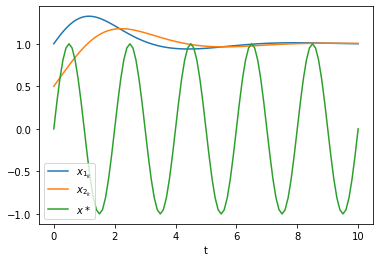

In [56]:

x1 = Variable('x_{1_k}')
x2 = Variable('x_{2_k}')
u = np.array([Variable('u_k')])
x = np.array([x1, x2])

# A and B matrices
Ak = np.array([[1.1-0.1*x[1],   0],
               [0.1         ,   0.9]])
Bk = np.array([1, 0])[:, np.newaxis]


dynamics= Ak @ x + Bk @ u
display_expression('x_{1_{k+1}}', dynamics[0])
display_expression('x_{2_{k+1}}', dynamics[1])

cstr_sys = SymbolicVectorSystem(state=x,
                           dynamics=dynamics,
                           input=u,
                           output=x,
                           time_period=0.1 # Discrete time system
                           )

builder = DiagramBuilder()
system = builder.AddSystem(cstr_sys)
builder.ExportInput(cstr_sys.get_input_port(0))
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()



context = diagram.CreateDefaultContext()
context.SetDiscreteState([1, 0.5])

system_context = diagram.GetMutableSubsystemContext(system, context)
system.get_input_port(0).FixValue(system_context, [0])

simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(),
         log.data().transpose(), log.sample_times(),
         np.sin(np.pi * log.sample_times()))
plt.legend([r'$x_{1_k}$', r'$x_{2_k}$', r'$x*$'])
plt.xlabel('t')
plt.show()